# SimGrid MPI calibration of a Grid5000 cluster

Copied from: https://github.com/Ezibenroc/calibration_analysis/blob/master/dahu/mpi/remote_calibration_adhoc.ipynb

packages
python
- pip install plotnine
- pip install pycewise

R
- install.packages("mclust")
- install.packages("Ckmeans.1d.dp")

## Utility classes and functions

### Dhist R

In [1]:
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
library(Ckmeans.1d.dp)

set.seed(42)

dhist<-function(x, a=5*iqr(x),
                 nbins=nclass.Sturges(x), rx = range(x,na.rm = TRUE),
                 eps=.15, xlab = "x", plot = TRUE,lab.spikes = TRUE)
 {

   if(is.character(nbins))
     nbins <- switch(casefold(nbins),
                     sturges = nclass.Sturges(x),
                     fd = nclass.FD(x),
                     scott = nclass.scott(x),
                     stop("Nclass method not recognized"))
   else if(is.function(nbins))
     nbins <- nbins(x)

   x <- sort(x[!is.na(x)])
   if(a == 0)
     a <- diff(range(x))/100000000
   if(a != 0 & a != Inf) {
     n <- length(x)
     h <- (rx[2] + a - rx[1])/nbins
     ybr <- rx[1] + h * (0:nbins)
     yupper <- x + (a * (1:n))/n
                                         # upper and lower corners in the ecdf
     ylower <- yupper - a/n
                                         #
     cmtx <- cbind(cut(yupper, breaks = ybr), cut(yupper, breaks = 
                                 ybr, left.include = TRUE), cut(ylower, breaks = ybr),
                   cut(ylower, breaks = ybr, left.include = TRUE))
     cmtx[1, 3] <- cmtx[1, 4] <- 1
                                         # to replace NAs when default r is used
     cmtx[n, 1] <- cmtx[n, 2] <- nbins
                                         #
                                         #checksum <- apply(cmtx, 1, sum) %% 4
     checksum <- (cmtx[, 1] + cmtx[, 2] + cmtx[, 3] + cmtx[, 4]) %%
     4
                                         # will be 2 for obs. that straddle two bins
     straddlers <- (1:n)[checksum == 2]
                                         # to allow for zero counts
     if(length(straddlers) > 0) {
       counts <- table(c(1:nbins, cmtx[ - straddlers, 1]))
     } else {
       counts <- table(c(1:nbins, cmtx[, 1]))
     }
     counts <- counts - 1
                                         #
     if(length(straddlers) > 0) {
       for(i in straddlers) {
         binno <- cmtx[i, 1]
         theta <- ((yupper[i] - ybr[binno]) * n)/a
         counts[binno - 1] <- counts[binno - 1] + (
                                                   1 - theta)
         counts[binno] <- counts[binno] + theta
       }
     }
     xbr <- ybr
     xbr[-1] <- ybr[-1] - (a * cumsum(counts))/n
     spike<-eps*diff(rx)/nbins
     flag.vec<-c(diff(xbr)<spike,F)
     if ( sum(abs(diff(xbr))<=spike) >1) {
       xbr.new<-xbr
       counts.new<-counts
       diff.xbr<-abs(diff(xbr))
       amt.spike<-diff.xbr[length(diff.xbr)]
       for (i in rev(2:length(diff.xbr))) {
         if (diff.xbr[i-1]<=spike&diff.xbr[i]<=spike&
             !is.na(diff.xbr[i])) {
           amt.spike<-amt.spike+diff.xbr[i-1]
           counts.new[i-1]<-counts.new[i-1]+counts.new[i]
           xbr.new[i]<-NA
           counts.new[i]<-NA
           flag.vec[i-1]<-T
         }
         else amt.spike<-diff.xbr[i-1]
       }
       flag.vec<-flag.vec[!is.na(xbr.new)]
       flag.vec<-flag.vec[-length(flag.vec)]
       counts<-counts.new[!is.na(counts.new)]
       xbr<-xbr.new[!is.na(xbr.new)]

     }
     else flag.vec<-flag.vec[-length(flag.vec)]
     widths <- abs(diff(xbr))
     ## N.B. argument "widths" in barplot must be xbr
     heights <- counts/widths
   }
   bin.size <- length(x)/nbins
   cut.pt <- unique(c(min(x) - abs(min(x))/1000,
                      approx(seq(length(x)), x, (1:(nbins - 1)) * bin.size, rule = 2)$y, max(x)))
   aa <- hist(x, breaks = cut.pt, plot = FALSE, probability = TRUE)
   if(a == Inf) {
     heights <- aa$counts
     xbr <- aa$breaks
   }
   amt.height<-3
   q75<-quantile(heights,.75)
   if (sum(flag.vec)!=0) {
     amt<-max(heights[!flag.vec])
     ylim.height<-amt*amt.height
     ind.h<-flag.vec&heights> ylim.height
     flag.vec[heights<ylim.height*(amt.height-1)/amt.height]<-F
     heights[ind.h] <- ylim.height
   }
   amt.txt<-0
   end.y<-(-10000)
   if(plot) {
     barplot(heights, abs(diff(xbr)), space = 0, density = -1, xlab = 
             xlab, plot = TRUE, xaxt = "n",yaxt='n')
     at <- pretty(xbr)
     axis(1, at = at - xbr[1], labels = as.character(at))
     if (lab.spikes) {
       if (sum(flag.vec)>=1) {
         usr<-par('usr')
         for ( i in seq(length(xbr)-1)) {
           if (!flag.vec[i]) {
             amt.txt<-0
             if (xbr[i]-xbr[1]<end.y) amt.txt<-1
           }
           else {
             amt.txt<-amt.txt+1
             end.y<-xbr[i]-xbr[1]+3*par('cxy')[1]
           }
           if (flag.vec[i]) {
             txt<-paste(' ',format(round(counts[i]/
                                         sum(counts)*100)),'%',sep='')
             par(xpd = TRUE)
             text(xbr[i+1]-xbr[1],ylim.height-par('cxy')[2]*(amt.txt-1),txt, adj=0)
           }}
       }
       else print('no spikes or more than one spike')
     }
     invisible(list(heights = heights, xbr = xbr))
   }
   else {
     return(list(heights = heights, xbr = xbr,counts=counts))
   }
 }

#' Calculate interquartile range
#'
#' Calculates the 25th and 75th quantiles given a vector x; used in function \link{dhist}.
#' @title Interquartile range
#' @param x vector
#' @return numeric vector of length 2, with the 25th and 75th quantiles of input vector x. 
iqr<-function(x){
   return(diff(quantile(x, c(0.25, 0.75), na.rm = TRUE)))
}

### Python

In [3]:
import os
import zipfile
import yaml
import pandas
import io
import numpy
from math import sqrt
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

class Util:
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return -self + other
    def __truediv__(self, other):
        return self * (1/other)
    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            return '%s(...)' % self.__class__.__name__

class Dhist(Util):
    '''
    Represents a histogram
    '''
    def __init__(self, data, log=False):
        if log:
            data = numpy.log(data)
        dhist = %R -i data dhist(data, plot=FALSE)
        print(dhist)

        self.log = log
        self.xbr = dhist[1]
        self.heights = dhist[0]
        assert len(self.xbr) == len(self.heights) + 1
        from scipy.stats import rv_histogram                                                                                                                  
        self.rv = rv_histogram((self.heights, self.xbr))
    
    def get_breaks(self):
        if self.log:
            return numpy.exp(self.xbr)
        else:
            return self.xbr

    def sample(self):
        rv_sample = self.rv.rvs(size=1)
        if self.log:
            return numpy.exp(rv_sample[0])
        else:
            return rv_sample[0]

    def to_c(self, variable_name):
        return "FIXME"
    
class LinearRegression(Util):
    '''
    Represent a linear relation of the form y ~ αx + β
    Note that both β can be of any type, including random variables.
    '''
    def __init__(self, intercept, coefficient):
        self.intercept = intercept
        self.coefficient = coefficient

    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            return 'Y ~ %sX + %s' % (self.coefficient, self.intercept)

    def to_tex(self):
        result =  r'Y \sim \alpha X + \beta\\'
        result += r'\alpha \sim %s\\' % self.coefficient.to_tex()
        result += r'\beta \sim %s\\' % self.intercept.to_tex()
        return result.replace(r'\\', '\\\\\n')

    def __add__(self, other):
        try:
            intercept = self.intercept + other.intercept
            coefficient = self.coefficient + other.coefficient
        except AttributeError:  # adding a constant
            intercept = self.intercept + other
            coefficient = self.coefficient
        return LinearRegression(intercept, coefficient)

    def __mul__(self, other):
        return LinearRegression(self.intercept*other, self.coefficient*other)

    def __neg__(self):
        return LinearRegression(-self.intercept, -self.coefficient)

    def sample(self, x, half=False):
        return self.coefficient * x + self.intercept.sample()

    def to_c(self, intercept_name, coefficient_name):
        return "FIXME"
        #return '\n'.join(variable.to_c(name) for name, variable in [(intercept_name, self.intercept), (coefficient_name, self.coefficient)])

print([LinearRegression(Dhist([1,2,3], [10, 10]), 1).sample(i) for i in range(5)])
print(LinearRegression(Dhist([1,2,3], [10, 10]), 1).to_c('intercept_smpi', 'coefficient_smpi'))

$heights

       1        2        3 
2.730718 2.730718 2.730718 

$xbr
[1] 0.0000000 0.3662041 0.7324082 1.0986123

$counts

1 2 3 
1 1 1 


$heights

       1        2        3 
2.730718 2.730718 2.730718 

$xbr
[1] 0.0000000 0.3662041 0.7324082 1.0986123

$counts

1 2 3 
1 1 1 


$heights

       1        2        3 
2.730718 2.730718 2.730718 

$xbr
[1] 0.0000000 0.3662041 0.7324082 1.0986123

$counts

1 2 3 
1 1 1 


$heights

       1        2        3 
2.730718 2.730718 2.730718 

$xbr
[1] 0.0000000 0.3662041 0.7324082 1.0986123

$counts

1 2 3 
1 1 1 


$heights

       1        2        3 
2.730718 2.730718 2.730718 

$xbr
[1] 0.0000000 0.3662041 0.7324082 1.0986123

$counts

1 2 3 
1 1 1 


[1.6068267641952718, 3.457331900551106, 3.4907411105079493, 4.4952877161175495, 6.589705354323572]
$heights

       1        2        3 
2.730718 2.730718 2.730718 

$xbr
[1] 0.0000000 0.3662041 0.7324082 1.0986123

$counts

1 2 3 
1 1 1 


FIXME


In [4]:
class SegmentedRegression(Util):
    def __init__(self):
        self.segments = []

    def append(self, regression, min_x, max_x):
        assert len(self.segments) == 0 or min_x == self.segments[-1][2]
        self.segments.append((regression, min_x, max_x))

    def to_tex(self):
        result = []
        for reg, min_x, max_x in self.segments:
            interval_string = ''
            if min_x is not None:
                interval_string += r'%s \leq ' % min_x
            interval_string += 'X'
            if max_x is not None:
                interval_string += r' < %s' % max_x
            result.append('%s\\\\\n%s' % (interval_string, reg.to_tex()))
        return '\\\\\n'.join(result)

    def __add__(self, other):
        result = self.__class__()
        if isinstance(other, self.__class__):
            for (dist1, min_x1, max_x1), (dist2, min_x2, max_x2) in zip(self.segments, other.segments):
                assert min_x1 == min_x2 and max_x1 == max_x2
                result.append(dist1 + dist2, min_x1, max_x1)
        else:
            for distribution, min_x, max_x in self.segments:
                result.append(distribution + other, min_x, max_x)
        return result

    def __mul__(self, other):
        result = self.__class__()
        for distribution, min_x, max_x in self.segments:
            result.append(distribution*other, min_x, max_x)
        return result

    def __neg__(self):
        return self*(-1)

    def sample(self, x):
        for reg, min_x, max_x in self.segments:
            min_x = min_x or float('-inf')
            max_x = max_x or float('inf')
            if min_x <= x <= max_x:
                return reg.sample(x)
        assert False

    def to_c(self):
        intercept_name = 'smpi_stochastic_intercept'
        coefficient_name = 'smpi_stochastic_coefficient'
        size_name = 'smpi_stochastic_size'
        reg_str = 'double %s=-1, %s=-1;\n' % (intercept_name, coefficient_name)
        for reg, min_x, max_x in self.segments:
            segment_str = reg.to_c(intercept_name, coefficient_name).split('\n')
            segment_str = ['    '+line for line in segment_str]
            segment_str = '\n'.join(segment_str)
            cond = []
            if min_x and abs(min_x) != float('inf'):
                cond.append('%d <= %s' % (min_x, size_name))
            if max_x and abs(max_x) != float('inf'):
                cond.append('%s < %d' % (size_name, max_x))
            cond = ' && '.join(cond) if cond else '1'
            reg_str += 'if(%s) {\n%s\n}\n' % (cond, segment_str)
        return reg_str

    
    def pretty_c(self):
        from IPython.display import Markdown, display
        display(Markdown('```c\n%s\n```' % self.to_c()))

In [5]:
def set_groups(df, reg_coeff):
    df['intercept_estimate'] = df['duration'] - df['msg_size'] * reg_coeff
    
    plot = ggplot(df[df.intercept_estimate > 0], aes(x='intercept_estimate')) + geom_histogram(bins=100) + theme_bw()
    plot = plot + ggtitle('Observed intercept (taking a coefficient of %.2e)' % reg_coeff)
        
    dhist = Dhist(df['intercept_estimate'], log=True)
    
    plot = plot + geom_vline(xintercept=dhist.get_breaks())

    print(plot)

    
    plot = ggplot(pandas.DataFrame({'intercept_estimate': [dhist.sample() for _ in range(len(df) if len(df) < 100000 else 100000)]}), aes(x='intercept_estimate')) + geom_histogram(bins=100) + theme_bw()
    plot = plot + ggtitle('Sampled intercept (taking a coefficient of %.2e)' % reg_coeff)
    print(plot)
        
    adhoc_reg = LinearRegression(
                    intercept = dhist,
                    coefficient = reg_coeff,
                )
    return adhoc_reg

def compute_mixture_regression(df, reg):
    df = df[df.msg_size > row["min_x"]]
    df = df[df.msg_size < row["max_x"]]
    df = df.copy()
    reg_coeff = max(0, reg["coefficient"])  # a negative coefficient does not make any sense (may happen with MPI_Irecv)
    adhoc_reg = set_groups(df, reg_coeff)
    return adhoc_reg


## Data extraction

In [6]:
archive_name = 'grenoble_2018-08-29_1808878.zip'

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'))['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name))
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

threshold = 64000

# I really hate that we have to define these two values:
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

result = extract_zip(archive_name)

In [7]:
!unzip -p $archive_name info.yaml

cluster: dahu
command: /home/tocornebize/.local/bin/peanut MPICalibration run tocornebize --jobid
  grenoble:1808878 --deploy debian9-x64-base --expfile exp.csv
dahu-11.grenoble.grid5000.fr:
  arp:
    dahu-15.grenoble.grid5000.fr:
    - (172.16.20.15) at 3c:fd:fe:55:ed:60 [ether] on enp24s0f0
    dns.grenoble.grid5000.fr:
    - (172.16.31.110) at 00:16:3e:4f:65:bf [ether] on enp24s0f0
    fgrenoble.grenoble.grid5000.fr:
    - (172.16.31.101) at 00:16:3e:06:dd:61 [ether] on enp24s0f0
    gw.grenoble.grid5000.fr:
    - (172.16.31.254) at 00:04:96:1d:09:40 [ether] on enp24s0f0
    kadeploy.grenoble.grid5000.fr:
    - (172.16.31.102) at 00:16:3e:c8:38:51 [ether] on enp24s0f0
  cpu: Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
  gcc: 6.3.0
  kernel: 4.9.0-7-amd64
  mpi: mpirun (Open MPI) 2.0.2
  version: 'Linux version 4.9.0-7-amd64 (debian-kernel@lists.debian.org) (gcc version
    6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u1 (2018-08-03)'
dahu-15.grenoble.grid5000.

In [8]:
# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']

## MPI_Send

x ≤ 8.133e+03?
    └──x ≤ 8.000e+00?
    │    └──y ~ 6.786e-09x + 2.064e-07
    │    └──x ≤ 4.778e+03?
    │         └──y ~ 7.795e-11x + 3.126e-07
    │         └──y ~ 1.458e-10x + 7.347e-40
    └──x ≤ 3.396e+04?
         └──y ~ 1.043e-10x + 4.052e-06
         └──x ≤ 6.330e+04?
              └──y ~ 1.263e-10x + 8.556e-06
              └──y ~ 8.110e-11x + 1.603e-05


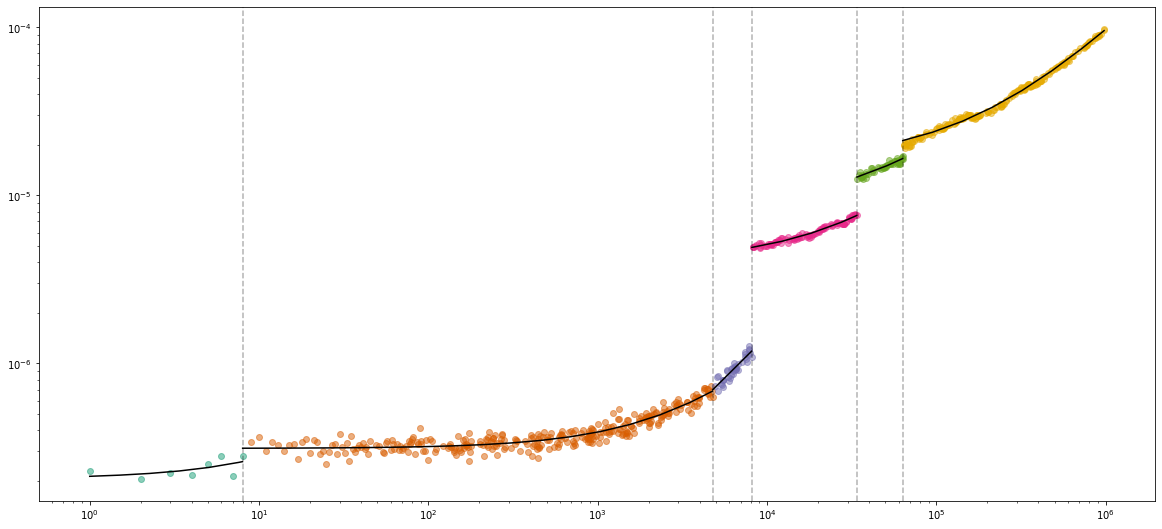

In [9]:
from pycewise import *

df_agg = aggregate_dataframe(df_send)
reg_send = compute_regression(df_agg['msg_size'], df_agg['duration'], mode='log')
print(reg_send)
reg_send.plot_dataset(log=True)

In [10]:
reg_send.to_pandas()

min_x    max_x     intercept   coefficient           RSS           MSE  \
0     -inf      8.0  2.064276e-07  6.785879e-09  3.984167e-15  4.980209e-16   
1      8.0   4778.0  3.126291e-07  7.794590e-11  3.118971e-13  9.901496e-16   
2   4778.0   8133.0  7.346840e-40  1.458088e-10  1.302755e-13  3.101798e-15   
3   8133.0  33956.0  4.052195e-06  1.042737e-10  1.840001e-12  1.786408e-14   
4  33956.0  63305.0  8.556209e-06  1.262608e-10  9.283729e-12  1.785332e-13   
5  63305.0      inf  1.603208e-05  8.109831e-11  2.459465e-10  1.205620e-12   

     RSSlog  weighted_RSS  statsmodels_intercept  statsmodels_coefficient  
0  0.068376  4.436866e-16           2.064663e-07             7.047881e-09  
1  2.053073  8.936655e-17           3.126459e-07             7.927045e-11  
2  0.148719  3.224656e-21          -3.338367e-08             1.512429e-10  
3  0.051036  7.126560e-21           4.052195e-06             1.044001e-10  
4  0.042916  4.239148e-21           8.556209e-06             1.263659e-10  
5  0.235232  1.240899e-20           1.603208e-05             8.107116e-11

$heights

          1           2           3           4           5           6 
4510.135322 5863.669177 7666.843201 2453.222423 1045.499552  347.102832 
          7           8           9          10          11          12 
1448.764591  211.473846    0.000000    0.000000    0.000000    0.000000 
         13 
   1.778268 

$xbr
 [1] -16.06457 -15.92689 -15.81466 -15.72461 -15.51456 -15.18650 -14.73162
 [8] -14.44904 -13.95726 -13.39423 -12.83120 -12.26817 -11.70514 -11.14279

$counts

       1        2        3        4        5        6        7        8 
620.9278 658.0722 690.4405 515.2837 342.9944 157.8873 409.3941 104.0000 
       9       10       11       12       13 
  0.0000   0.0000   0.0000   0.0000   1.0000 




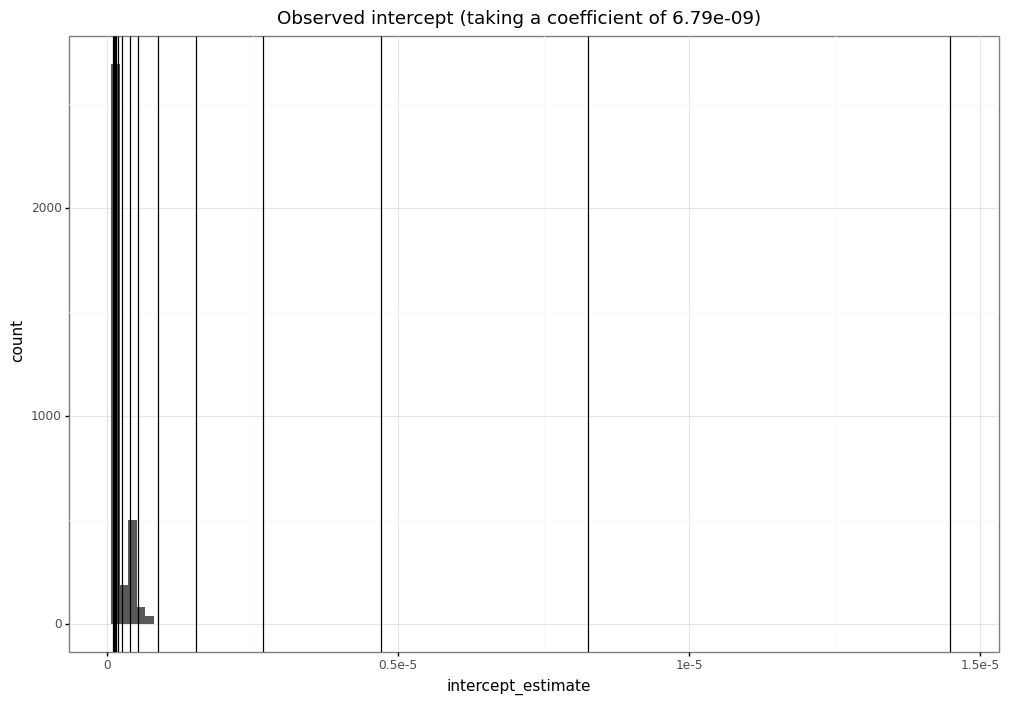

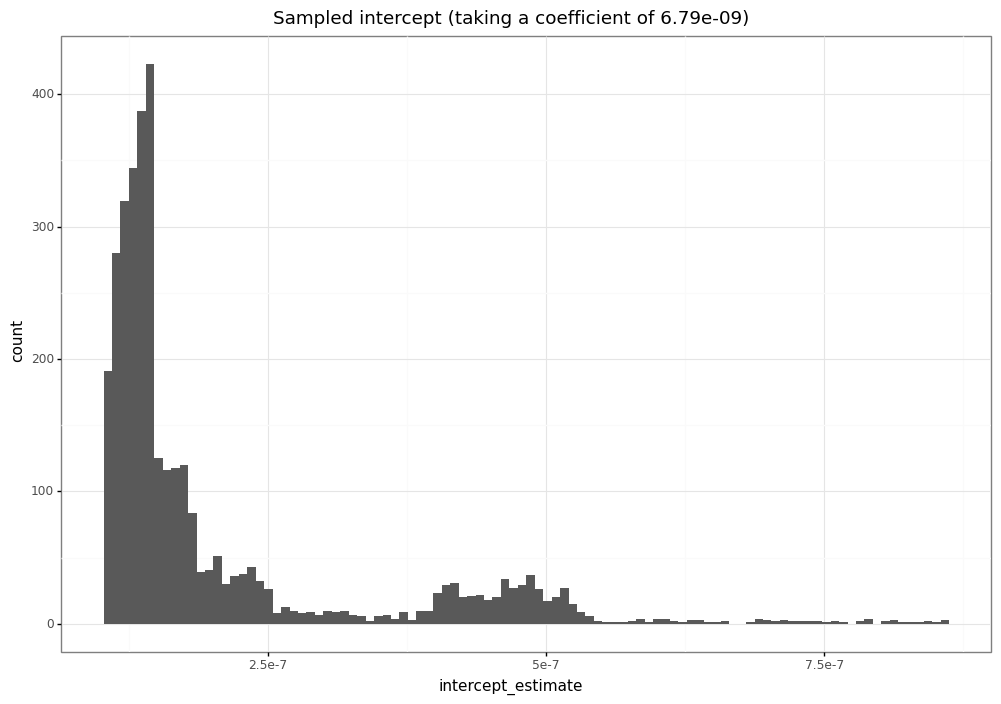


$heights

           1            2            3            4            5            6 
6.599518e+02 1.598257e+04 7.021331e+04 2.406947e+05 4.532636e+05 3.808152e+05 
           7            8            9           10           11           12 
1.150331e+05 6.240106e+04 2.202204e+04 1.533505e+04 7.578124e+04 3.400145e+04 
          13           14           15           16           17           18 
7.502483e+03 1.588243e+02 4.952089e+00 2.476764e+01 4.952089e+00 1.238157e+01 
          19 
7.435691e+01 

$xbr
 [1] -16.47787 -16.07784 -15.75061 -15.55157 -15.46238 -15.40954 -15.34818
 [8] -15.19783 -14.98689 -14.68156 -14.35179 -14.16045 -13.89090 -13.52702
[15] -13.12406 -12.72019 -12.31644 -11.91257 -11.50874 -11.10528

$counts

       1        2        3        4        5        6        7        8 
  264.00  5230.00 13975.00 21468.15 23948.30 23366.78 17295.84 13162.93 
       9       10       11       12       13       14       15       16 
 6724.00  5057.00 14500.00  9165.00  

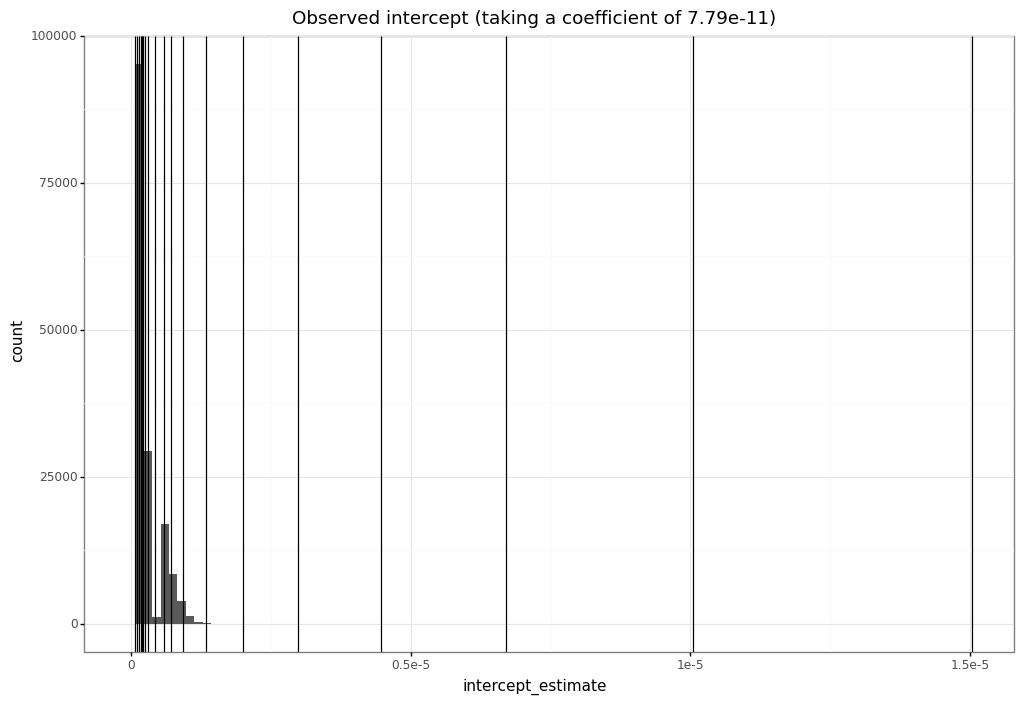

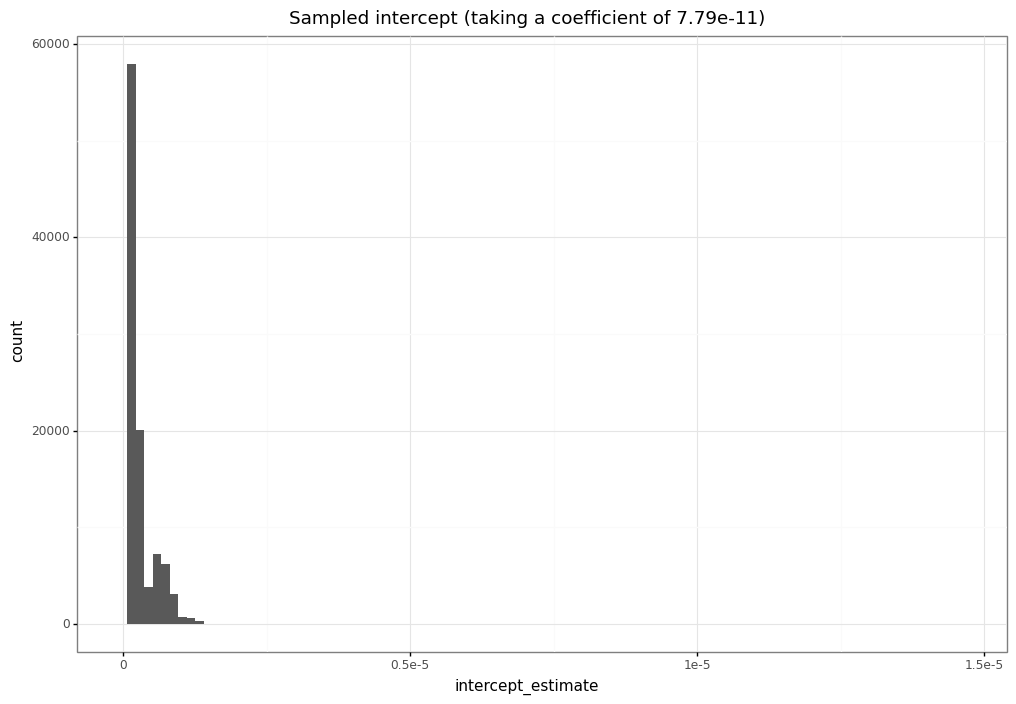


$heights

          1           2           3           4           5           6 
   1.132583    2.266100    4.535943    2.266100    7.947746   19.381805 
          7           8           9          10          11          12 
  63.710982  114.389627  174.593705  225.407994 2075.030742 7165.932439 
         13          14          15          16 
3286.090112  192.633540    3.400553   18.234128 

$xbr
 [1] -23.44672 -22.56378 -21.68121 -20.79936 -19.91679 -19.03604 -18.15892
 [8] -17.29565 -16.44767 -15.61717 -14.80088 -14.29775 -14.05303 -13.65092
[15] -12.82552 -11.94331 -11.06583

$counts

       1        2        3        4        5        6        7        8 
   1.000    2.000    4.000    2.000    7.000   17.000   55.000   97.000 
       9       10       11       12       13       14       15       16 
 145.000  184.000 1044.000 1753.616 1321.384  159.000    3.000   16.000 




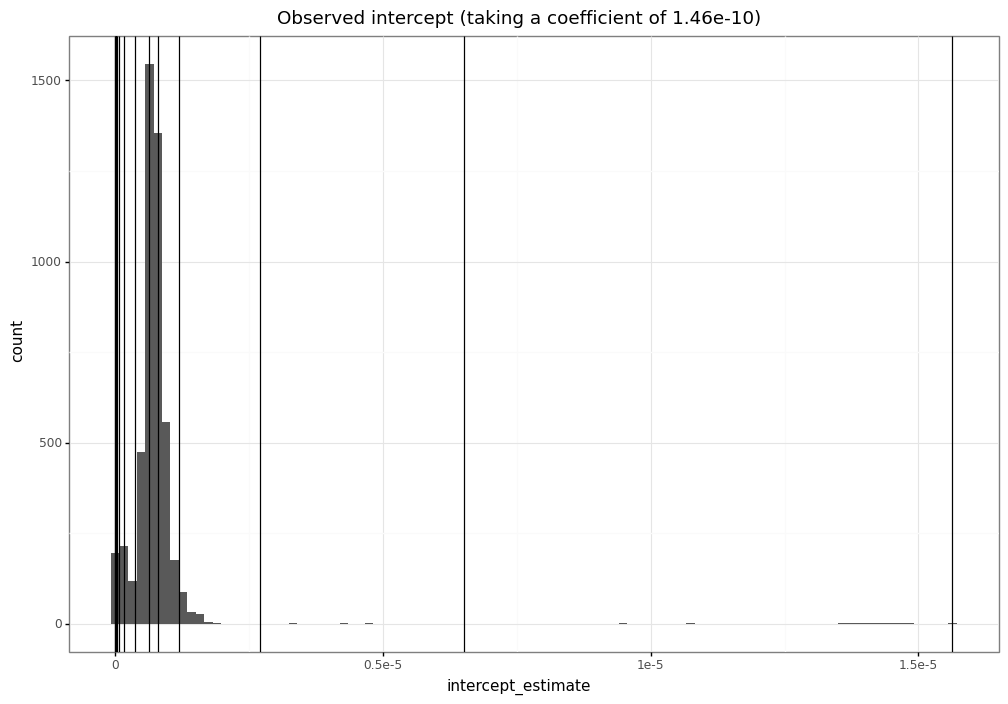

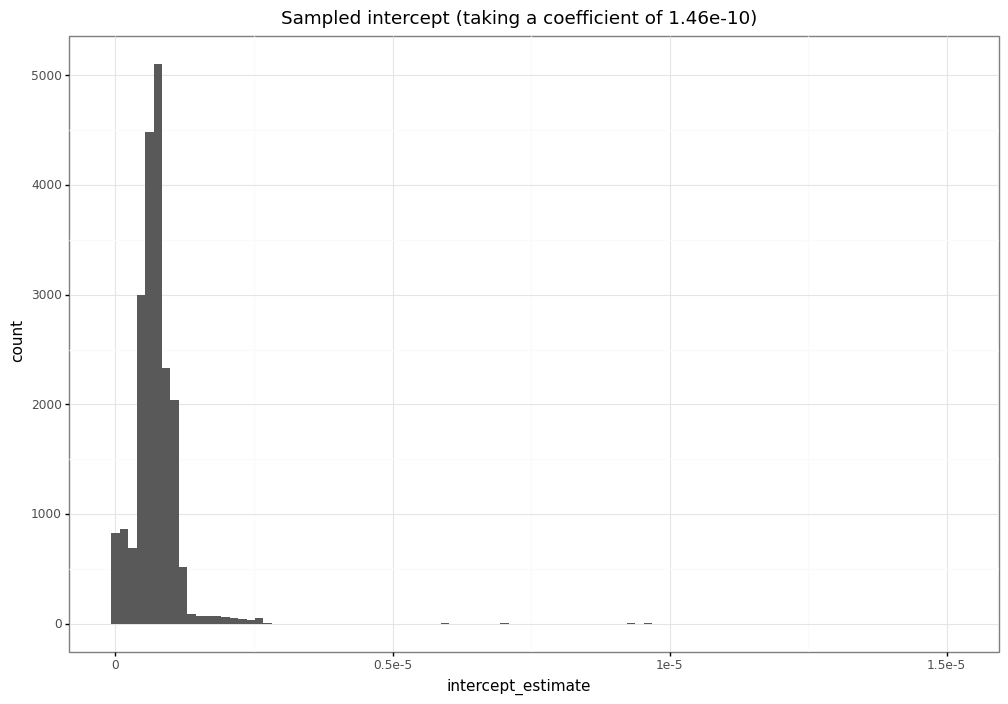


$heights

           1            2            3            4            5            6 
 17019.81597 156929.31936 247960.32222 272159.98095 222808.47660  41572.49909 
           7            8            9           10           11           12 
 51030.59605  26709.53854  23861.00506   4219.29660    182.10492     73.84149 
          13           14           15           16           17 
   457.43193   2417.59043    290.77564    411.36200     39.73729 

$xbr
 [1] -12.75237 -12.61630 -12.56898 -12.53575 -12.50496 -12.46876 -12.36638
 [8] -12.27292 -12.15249 -12.02785 -11.86361 -11.68789 -11.51183 -11.33694
[15] -11.16777 -10.99237 -10.81735 -10.64119

$counts

       1        2        3        4        5        6        7        8 
2315.832 7426.594 8238.574 8379.000 8066.935 4256.065 4769.452 3216.548 
       9       10       11       12       13       14       15       16 
2974.000  693.000   32.000   13.000   80.000  409.000   51.000   72.000 
      17 
   7.000 




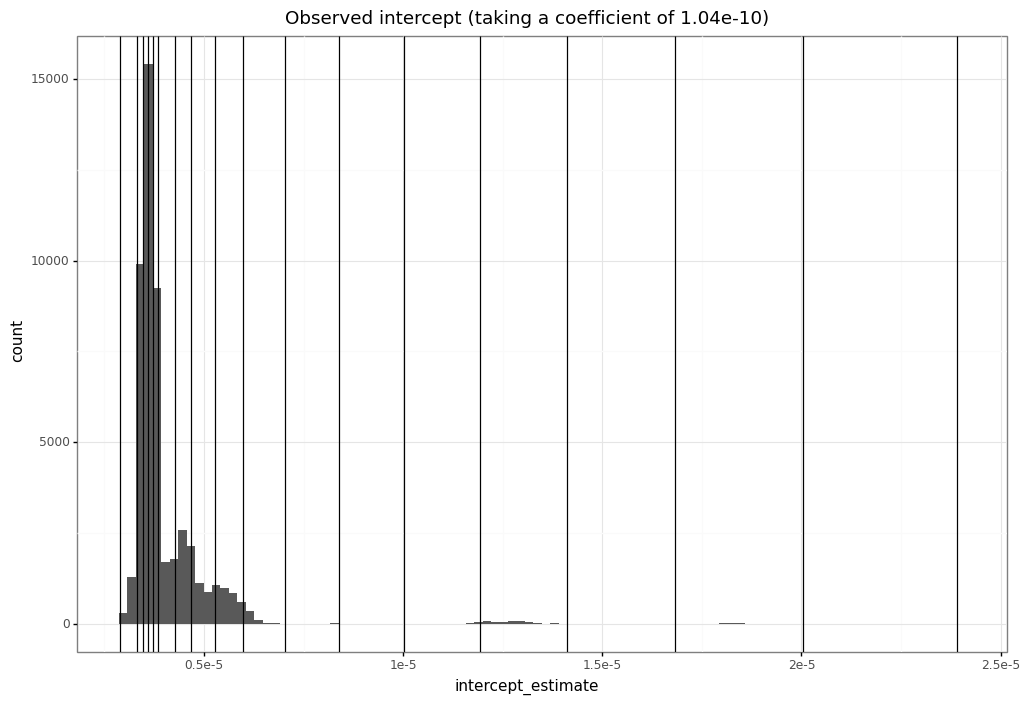

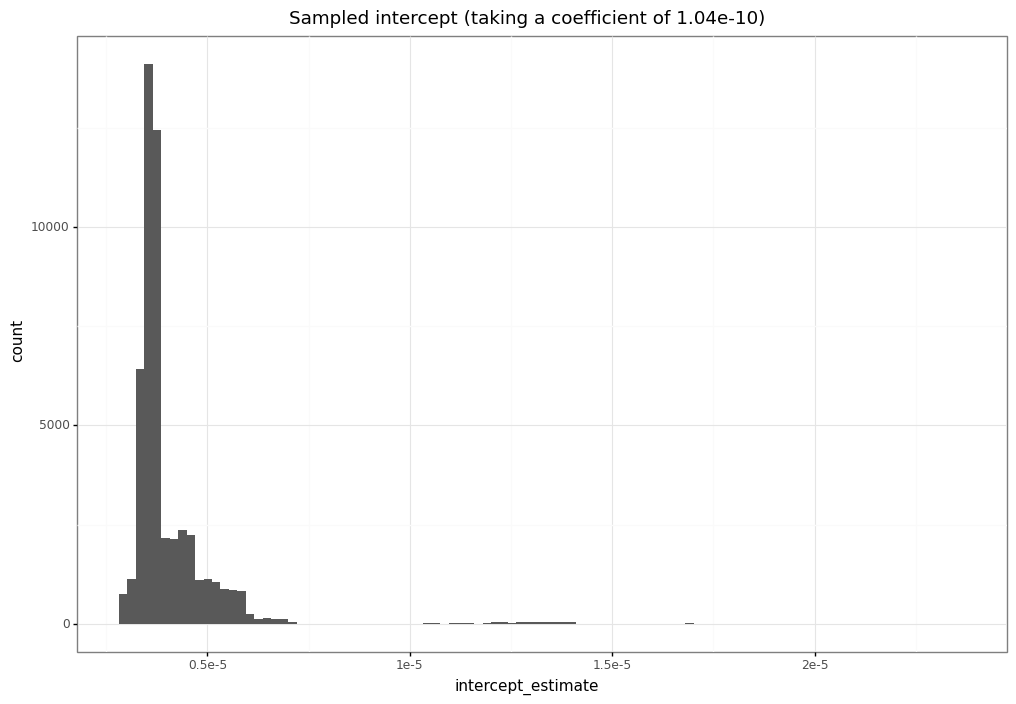


$heights

           1            2            3            4            5            6 
 11155.94414 105676.17826 154140.10757 143838.69081  58693.48419   3868.24142 
           7            8            9           10           11           12 
   190.69656    168.62244     21.93298  12113.68541  26669.48039   4361.12778 
          13           14           15           16 
   161.26852    427.31009    442.16900    168.62244 

$xbr
 [1] -12.05635 -11.94349 -11.89807 -11.86330 -11.82671 -11.76210 -11.63465
 [8] -11.49831 -11.36191 -11.22513 -11.11394 -11.02320 -10.89685 -10.76044
[15] -10.62470 -10.48901 -10.35261

$counts

       1        2        3        4        5        6        7        8 
1259.044 4799.933 5359.253 5263.473 3792.297  493.000   26.000   23.000 
       9       10       11       12       13       14       15       16 
   3.000 1346.870 2420.130  551.000   22.000   58.000   60.000   23.000 




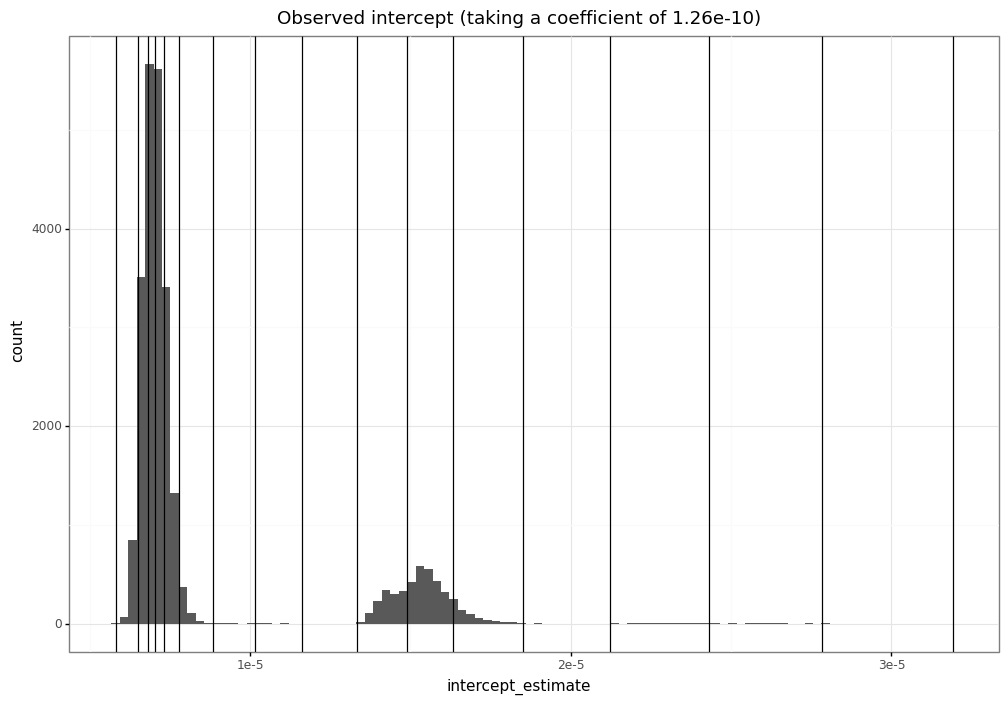

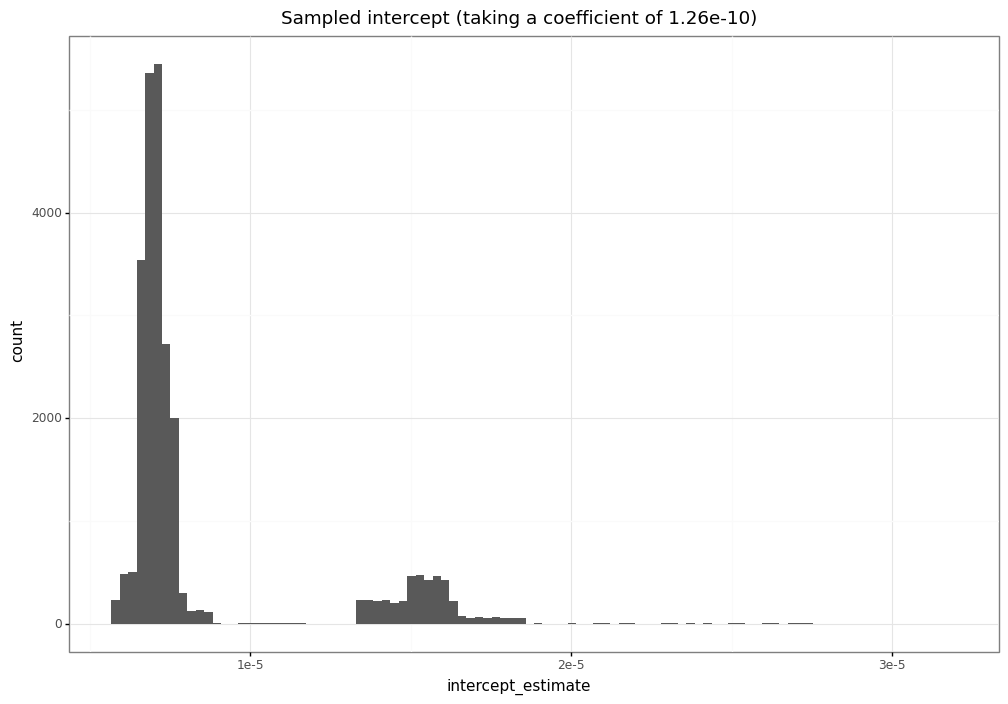


$heights

          1           2           3           4           5           6 
 12547.4842 175419.0077 360497.9513 399996.7665 306794.7175 291117.6380 
          7           8           9          10          11          12 
216035.7687  43891.9927    524.4677  11685.3846  30805.6082  13953.6087 
         13          14          15          16          17          18 
  7311.9175   9321.5047   4836.6014   3600.7300   2242.1380    338.5019 

$xbr
 [1] -11.487047 -11.343892 -11.277098 -11.235511 -11.197024 -11.150323
 [7] -11.101884 -11.042931 -10.925593 -10.769244 -10.625218 -10.498325
[13] -10.356570 -10.207954 -10.061483  -9.910137  -9.757390  -9.603073
[19]  -9.446501

$counts

        1         2         3         4         5         6         7         8 
 1796.229 11716.979 14991.940 15394.665 14327.533 14101.619 12735.805  5150.229 
        9        10        11        12        13        14        15        16 
   82.000  1683.000  3909.000  1978.000  1086.668  1365.332   7

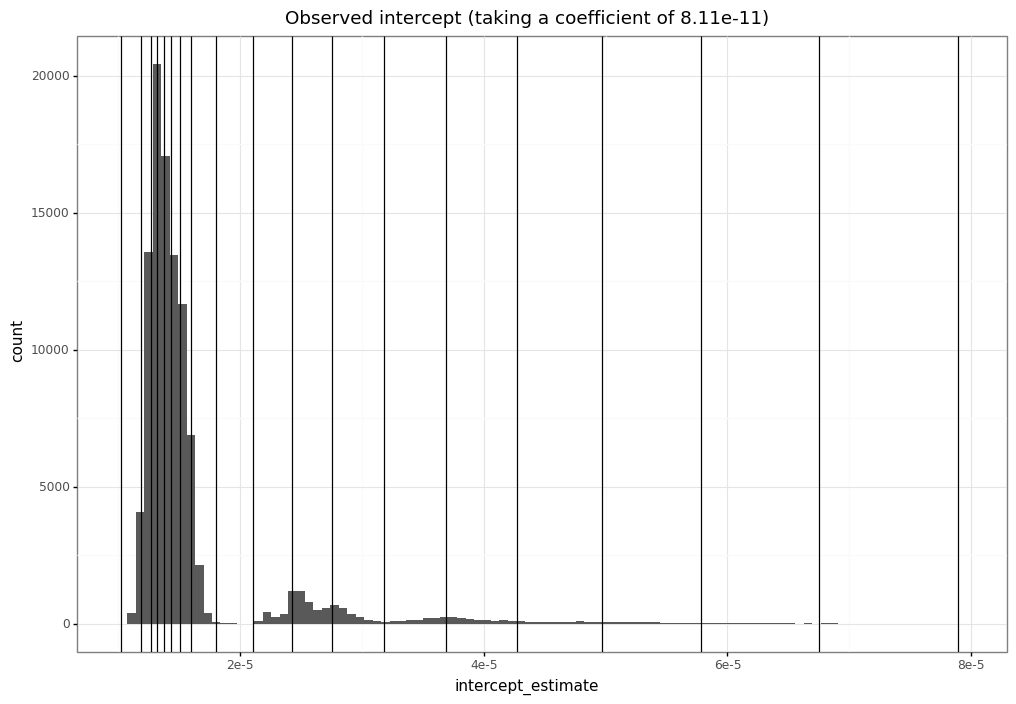

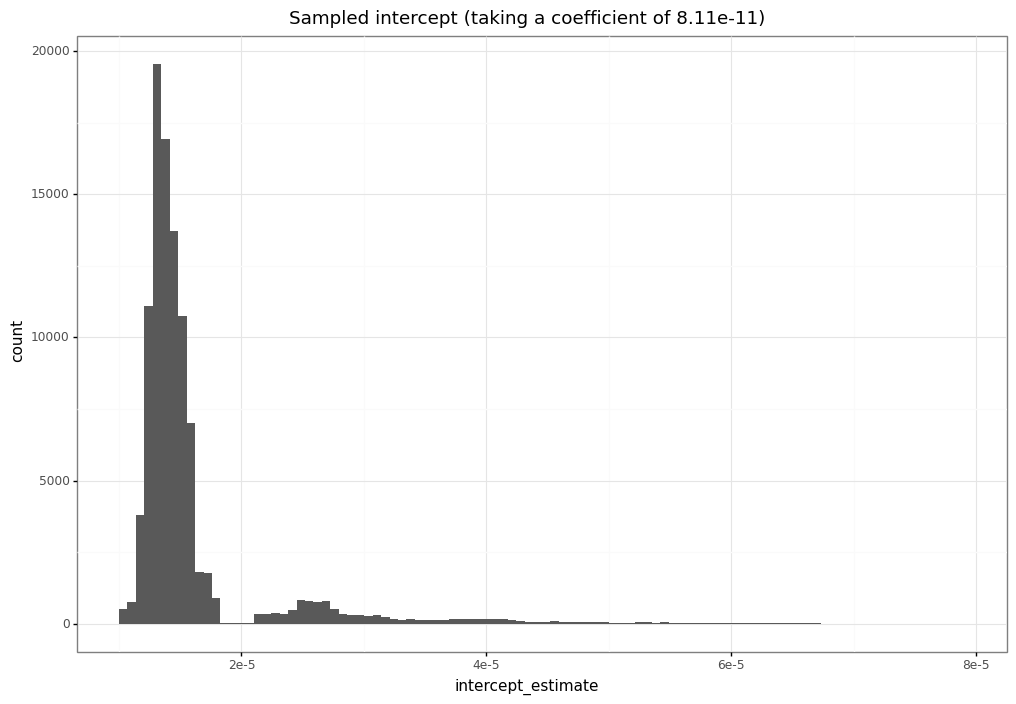

In [11]:
regressions_send = SegmentedRegression()

for i, row in reg_send.to_pandas().iterrows():
    regressions_send.append(compute_mixture_regression(df_send, row), row["min_x"], row["max_x"])


## Verification: generating the send durations

In [12]:
send_generated = pandas.DataFrame(dict(msg_size=df_send.sample(n=100000).msg_size))
send_generated['duration'] = send_generated.apply(lambda row: regressions_send.sample(row['msg_size']), axis=1)
#pingpong_generated.loc[pingpong_generated.msg_size <= threshold, 'duration'] = pingpong_generated.apply(lambda row: small_size_model.sample(row['msg_size']), axis=1)
#pingpong_generated.loc[pingpong_generated.msg_size >  threshold, 'duration'] = pingpong_generated.apply(lambda row: large_size_model.sample(row['msg_size']), axis=1)
send_generated.head()

msg_size      duration
47136       8984  6.096457e-06
338720       264  2.412329e-07
2836      209048  2.915968e-05
233633      7803  2.048019e-06
258006      6744  1.613569e-06

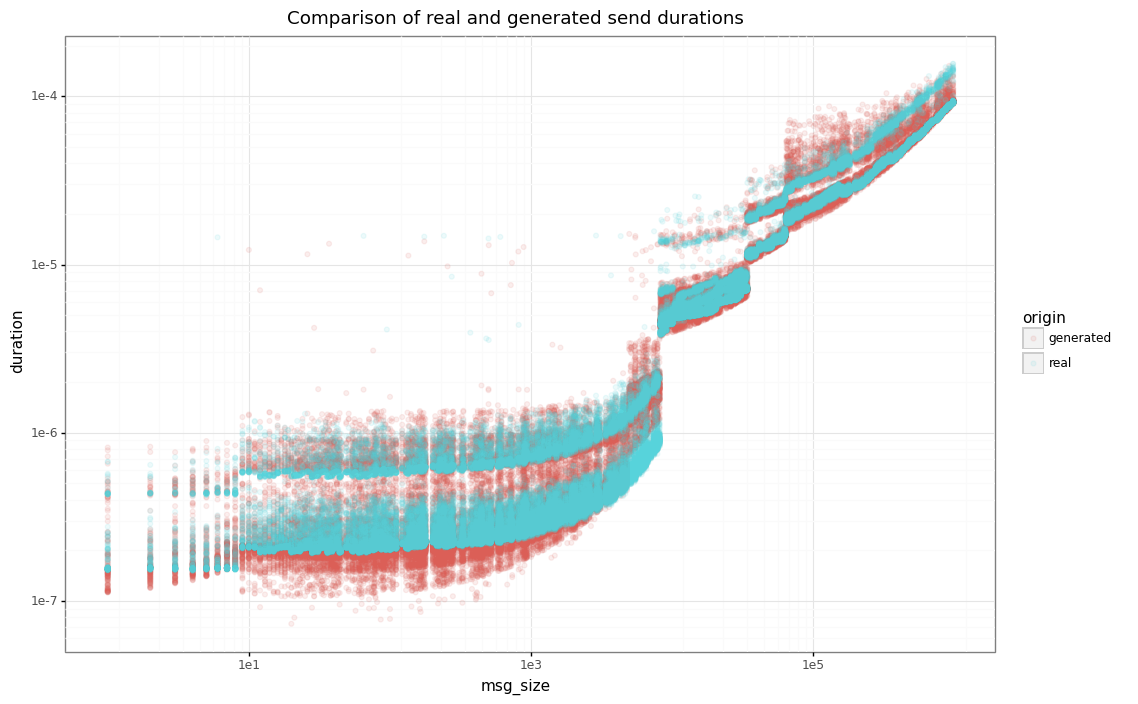

<ggplot: (8779366851810)>

In [13]:
df_send['origin'] = 'real'
send_generated['origin'] = 'generated'
tmp = pandas.concat([send_generated, df_send.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + ggtitle('Comparison of real and generated send durations')
plot

## MPI_Isend

x ≤ 6.330e+04?
    └──x ≤ 1.583e+04?
    │    └──x ≤ 1.008e+04?
    │    │    └──x ≤ 1.500e+01?
    │    │    │    └──y ~ 7.492e-09x + 7.141e-07
    │    │    │    └──y ~ 7.202e-11x + 6.751e-07
    │    │    └──y ~ 5.344e-11x + 1.329e-06
    │    └──y ~ 3.185e-11x + 3.192e-06
    └──x ≤ 1.970e+05?
         └──y ~ 3.503e-46x + 6.930e-07
         └──y ~ 1.401e-45x + 6.662e-07


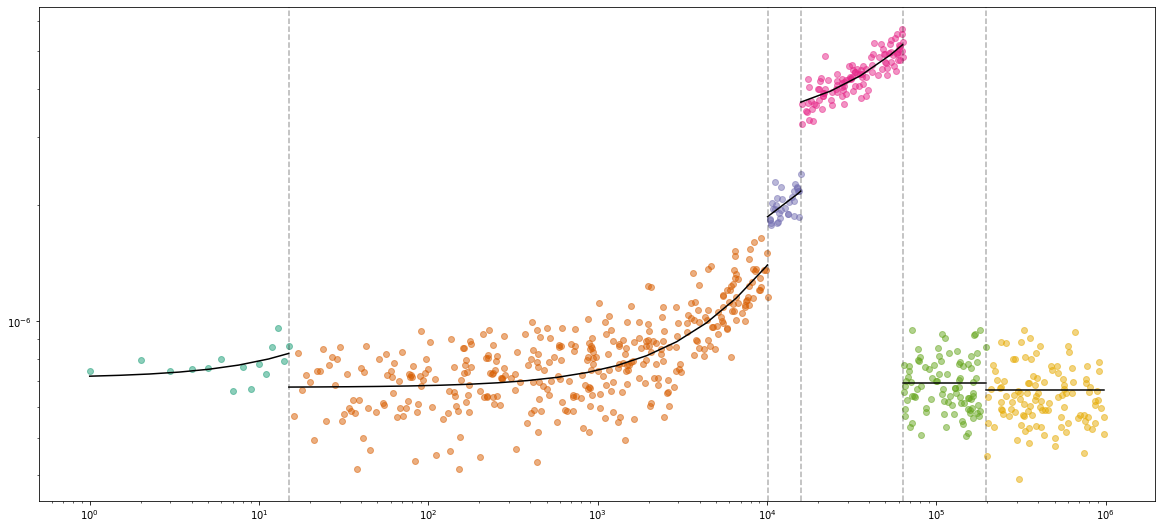

In [14]:
df_agg = aggregate_dataframe(df_isend)
reg_isend = compute_regression(df_agg['msg_size'], df_agg['duration'], mode='log')
print(reg_isend)
reg_isend.plot_dataset(log=True)

In [15]:
reg_isend.to_pandas()

min_x     max_x     intercept   coefficient           RSS           MSE  \
0      -inf      15.0  7.140545e-07  7.492430e-09  6.303000e-14  4.202000e-15   
1      15.0   10079.0  6.751044e-07  7.202421e-11  7.115027e-12  1.954678e-14   
2   10079.0   15831.0  1.328510e-06  5.344318e-11  6.227978e-13  1.946243e-14   
3   15831.0   63305.0  3.191591e-06  3.185382e-11  9.044002e-12  8.297250e-14   
4   63305.0  196988.0  6.929840e-07  3.503246e-46  1.098566e-12  1.194094e-14   
5  196988.0       inf  6.661893e-07  7.006492e-46  1.396192e-12  1.246600e-14   

      RSSlog  weighted_RSS  statsmodels_intercept  statsmodels_coefficient  
0   0.102732  2.150331e-15           7.140857e-07             7.918893e-09  
1  11.185148  6.666098e-16           6.874325e-07             7.180356e-11  
2   0.149617  3.947812e-21           1.328510e-06             5.381846e-11  
3   0.478809  1.101285e-20           3.191591e-06             3.206163e-11  
4   2.240321  9.523349e-23           6.929840e-07            -1.421397e-14  
5   3.446781  1.153646e-23           6.661893e-07            -3.948743e-14

$heights

          1           2           3           4           5           6 
2608.810428 7407.605546 8888.720309 7767.862261 3861.349381 1360.362859 
          7           8           9          10          11          12 
2113.598082 1955.451217  235.047268    1.361272    0.000000    0.000000 
         13          14 
 142.800898   33.271019 

$xbr
 [1] -16.07786 -15.78424 -15.64474 -15.52469 -15.39047 -15.16257 -14.75052
 [8] -14.41911 -14.07351 -13.42605 -12.69144 -11.95626 -11.22108 -10.54181
[15]  -9.82046

$counts

        1         2         3         4         5         6         7         8 
 766.0000 1033.3601 1067.0991 1042.5346  880.0062  560.5450  700.4550  675.8170 
        9        10        11        12        13        14 
 152.1830    1.0000    0.0000    0.0000   97.0000   24.0000 




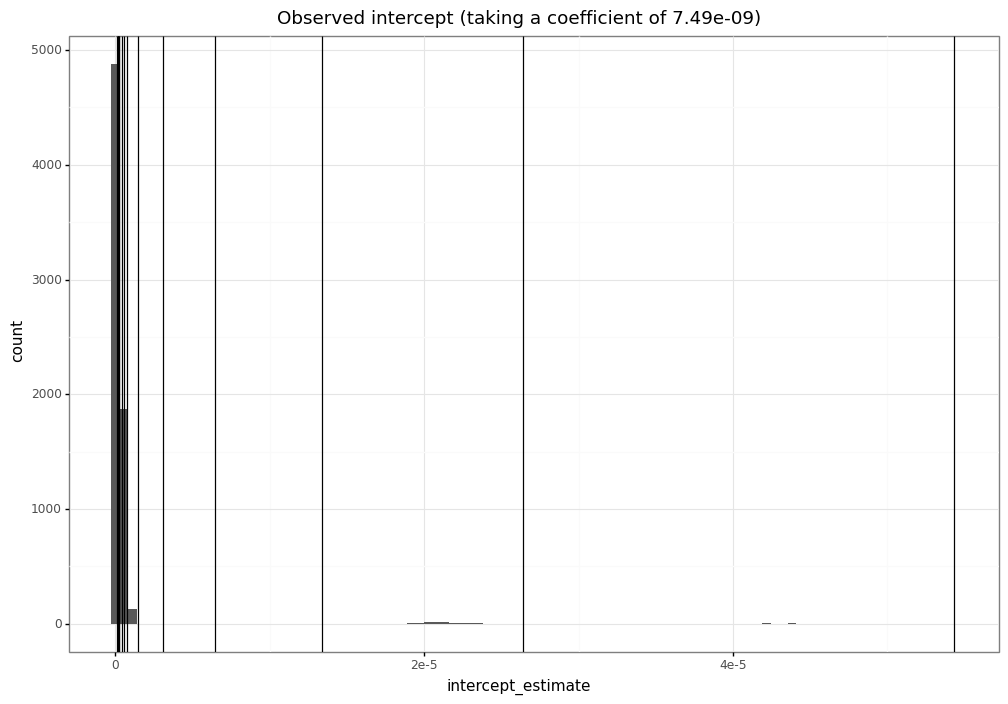

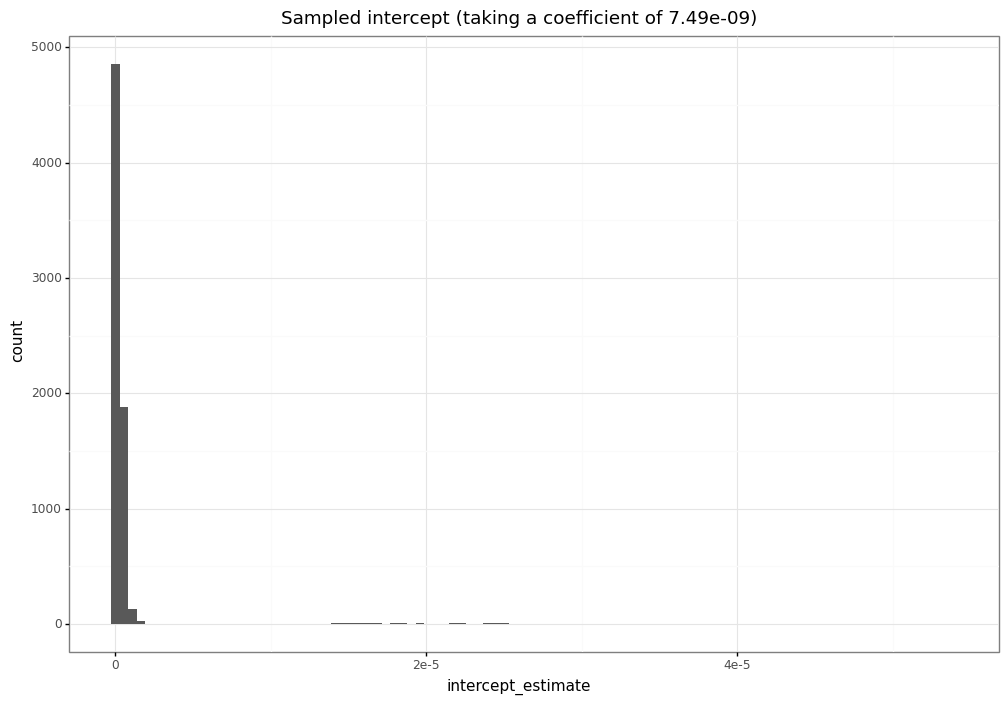


$heights

           1            2            3            4            5            6 
    10.45605     19.42146    118.22907   1734.79110  16303.35378  51826.39646 
           7            8            9           10           11           12 
122954.15747 252949.94570 198504.69171  72093.96836  13729.40032  90431.57448 
          13           14           15           16           17           18 
 26241.67067   1405.07693     31.37977     10.45605     83.75692   3196.92160 
          19 
   735.25972 

$xbr
 [1] -19.176300 -18.506832 -17.837469 -17.169275 -16.519629 -15.999981
 [7] -15.650738 -15.439919 -15.317663 -15.169303 -14.875104 -14.336411
[13] -14.078928 -13.621696 -12.968351 -12.299130 -11.629662 -10.961060
[19] -10.327326  -9.666335

$counts

        1         2         3         4         5         6         7         8 
    7.000    13.000    79.000  1127.000  8472.000 18100.000 25921.060 30924.879 
        9        10        11        12        13        14        15

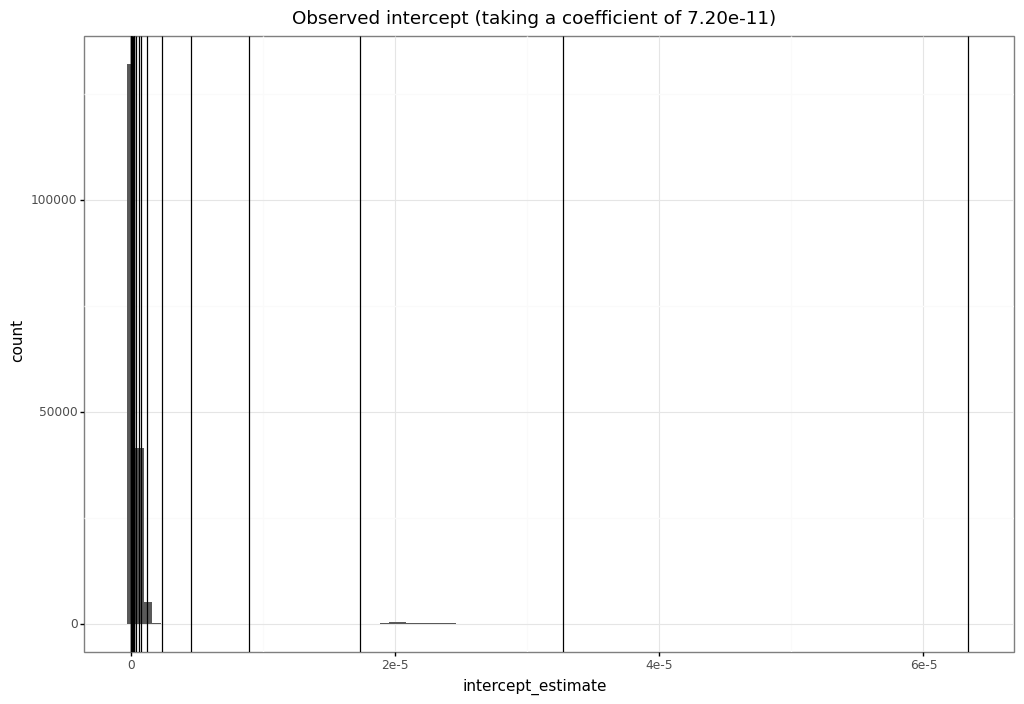

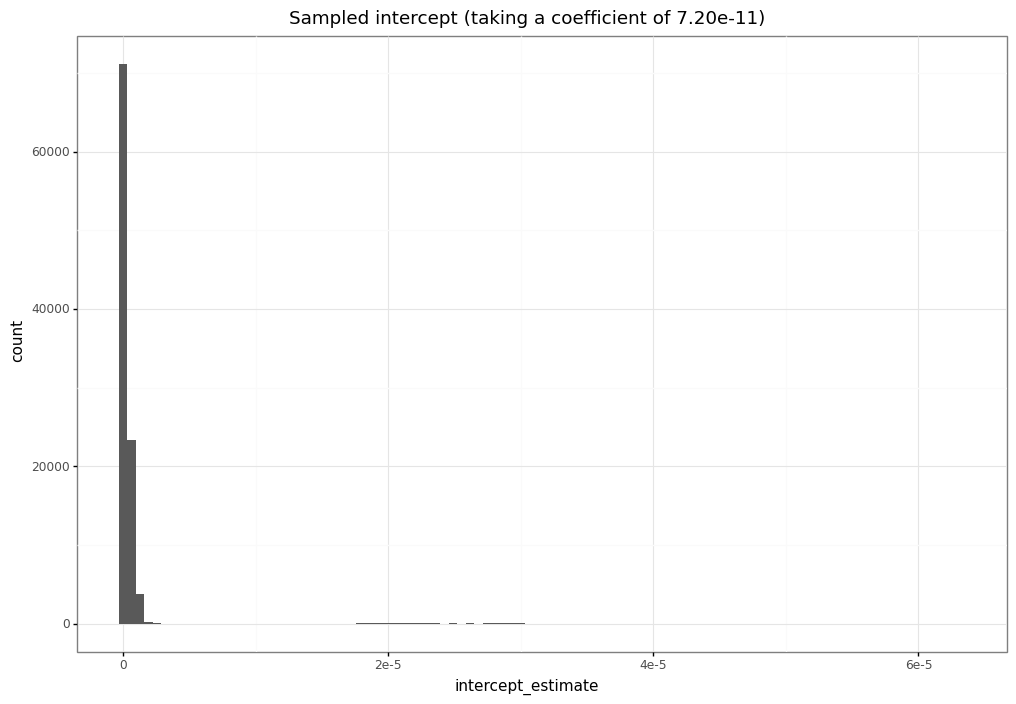


$heights

           1            2            3            4            5            6 
32071.723742 74630.943568  9992.543354   461.956217  6410.057543  3992.917056 
           7            8            9           10           11           12 
  154.519004     0.000000     0.000000     0.000000     2.839793   111.356569 
          13           14           15 
  382.003052     0.000000   131.475865 

$xbr
 [1] -14.260192 -14.125445 -14.051379 -13.817021 -13.472833 -13.206532
 [7] -12.913263 -12.563791 -12.211603 -11.859414 -11.507226 -11.155087
[13] -10.804861 -10.459314 -10.107125  -9.757251

$counts

       1        2        3        4        5        6        7        8 
4321.572 5527.593 2341.835  159.000 1707.000 1171.000   54.000    0.000 
       9       10       11       12       13       14       15 
   0.000    0.000    1.000   39.000  132.000    0.000   46.000 




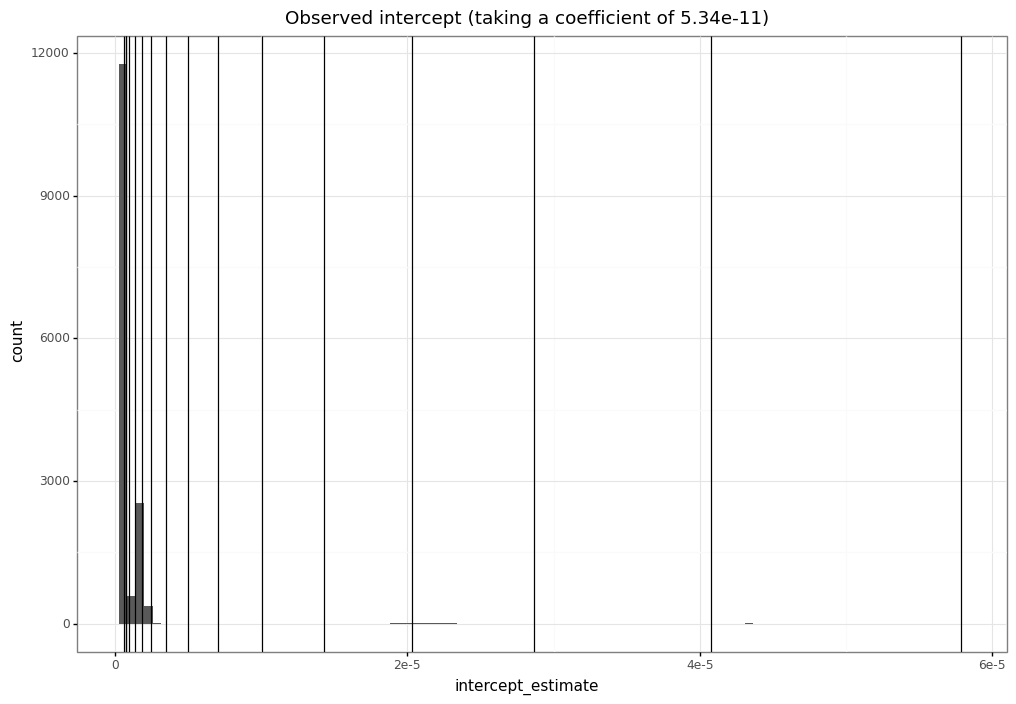

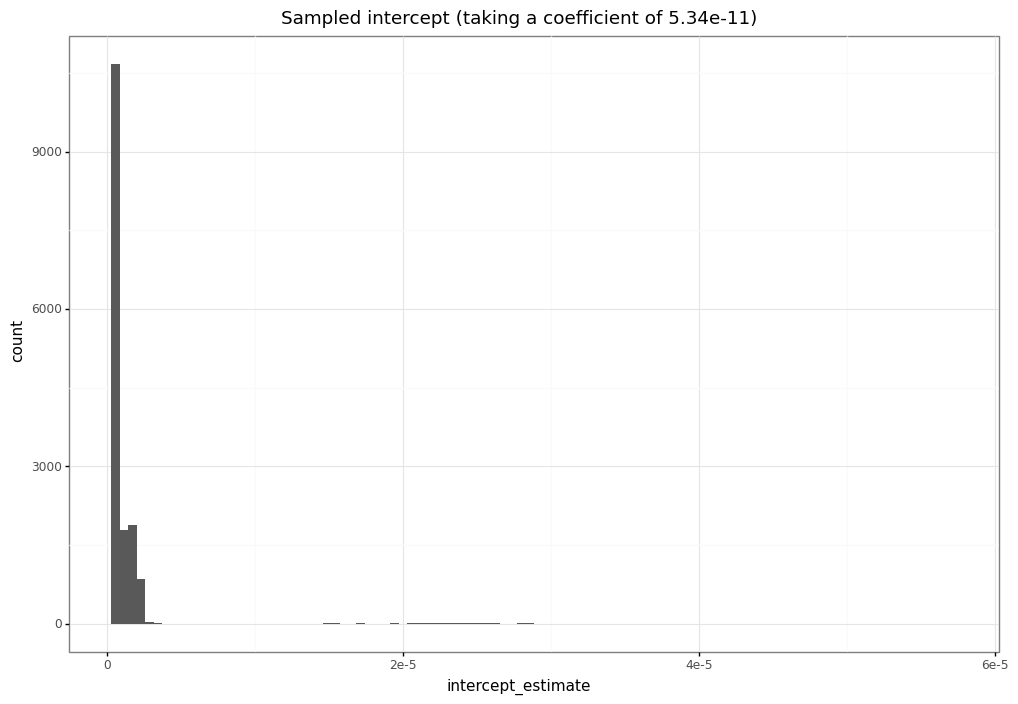


$heights

           1            2            3            4            5            6 
 15379.27448 128044.59158 215145.20065 114637.40478  22398.94315    579.58475 
           7            8            9           10           11           12 
    16.97310  11077.88899  28751.50030   5032.05658     20.36899    173.62088 
          13           14           15           16           17 
  1689.68236    732.50155     10.18260    437.85087     44.15197 

$xbr
 [1] -13.513545 -13.283495 -13.195239 -13.135465 -13.040224 -12.831107
 [7] -12.539519 -12.244935 -11.999852 -11.806645 -11.536775 -11.242210
[13] -10.948466 -10.662614 -10.371829 -10.077209  -9.784872  -9.490434

$counts

       1        2        3        4        5        6        7        8 
 3538.00 11300.71 12860.02 10918.27  4684.00   169.00     5.00  2715.00 
       9       10       11       12       13       14       15       16 
 5555.00  1358.00     6.00    51.00   483.00   213.00     3.00   128.00 
      17 
   13.00 


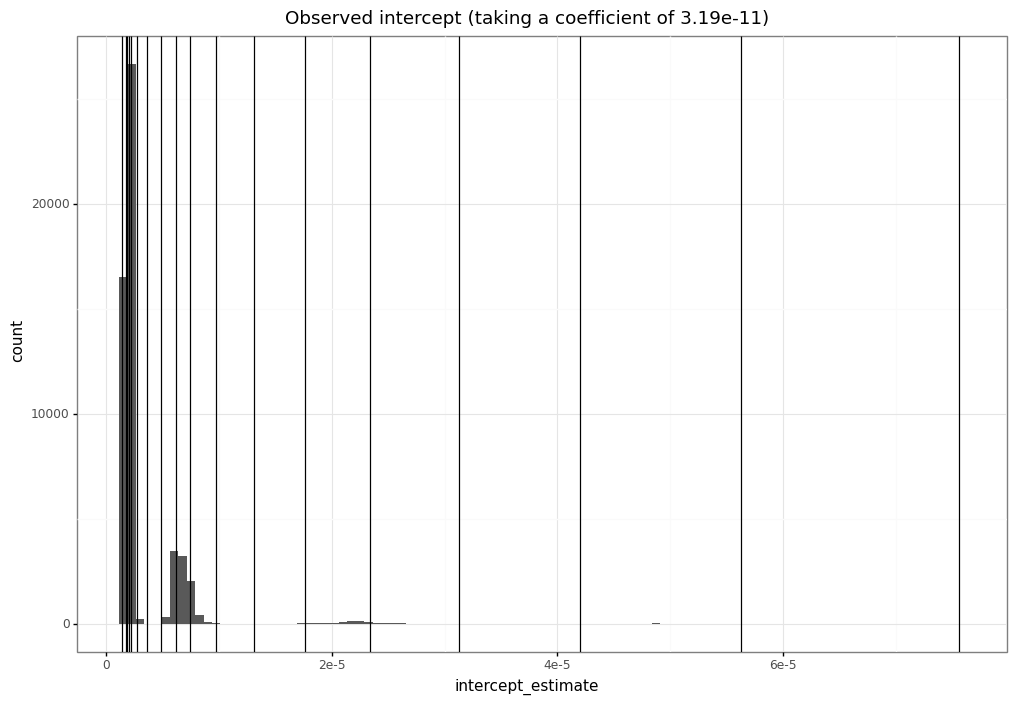

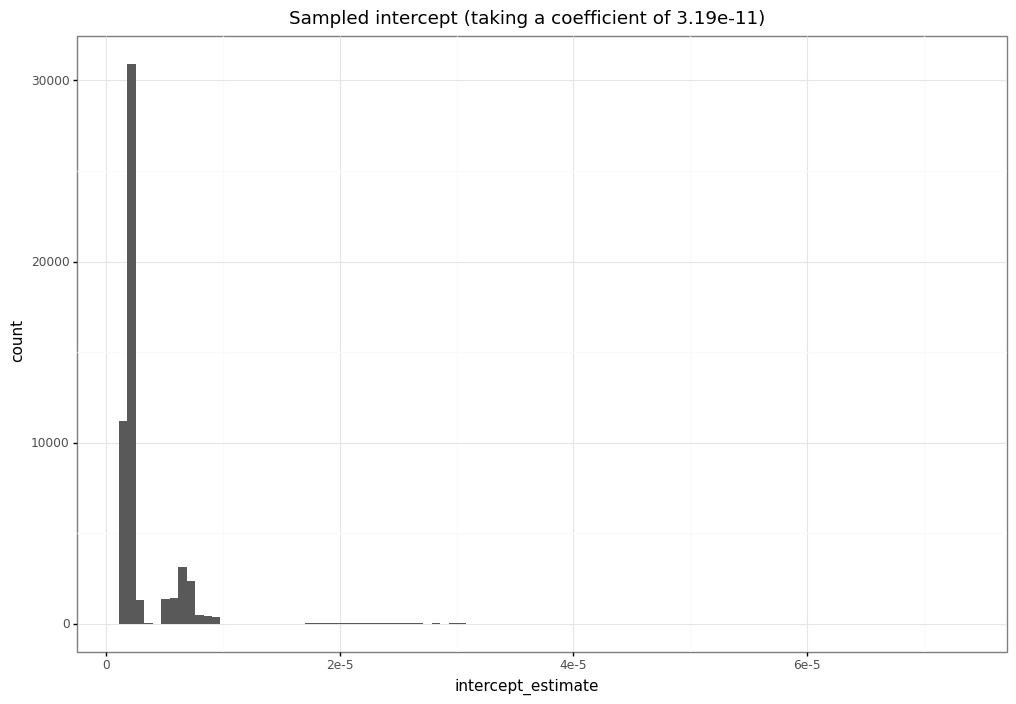


$heights

           1            2            3            4            5            6 
6.105935e+04 1.456040e+05 8.982020e+04 1.583859e+04 1.114600e+03 2.109592e+04 
           7            8            9           10           11           12 
3.368833e+03 5.437484e+01 0.000000e+00 0.000000e+00 7.405797e+00 0.000000e+00 
          13           14           15           16           17 
2.468285e+00 1.138667e+02 1.332563e+03 6.180138e+01 1.486545e+02 

$xbr
 [1] -15.371408 -15.213878 -15.128554 -15.006238 -14.718431 -14.324568
 [7] -14.062005 -13.689176 -13.284577 -12.879412 -12.474246 -12.069158
[13] -11.663993 -11.258853 -10.854872 -10.463146 -10.058624  -9.655004

$counts

        1         2         3         4         5         6         7         8 
 9618.692 12423.376 10986.476  4558.456   439.000  5539.000  1256.000    22.000 
        9        10        11        12        13        14        15        16 
    0.000     0.000     3.000     0.000     1.000    46.000   522.000

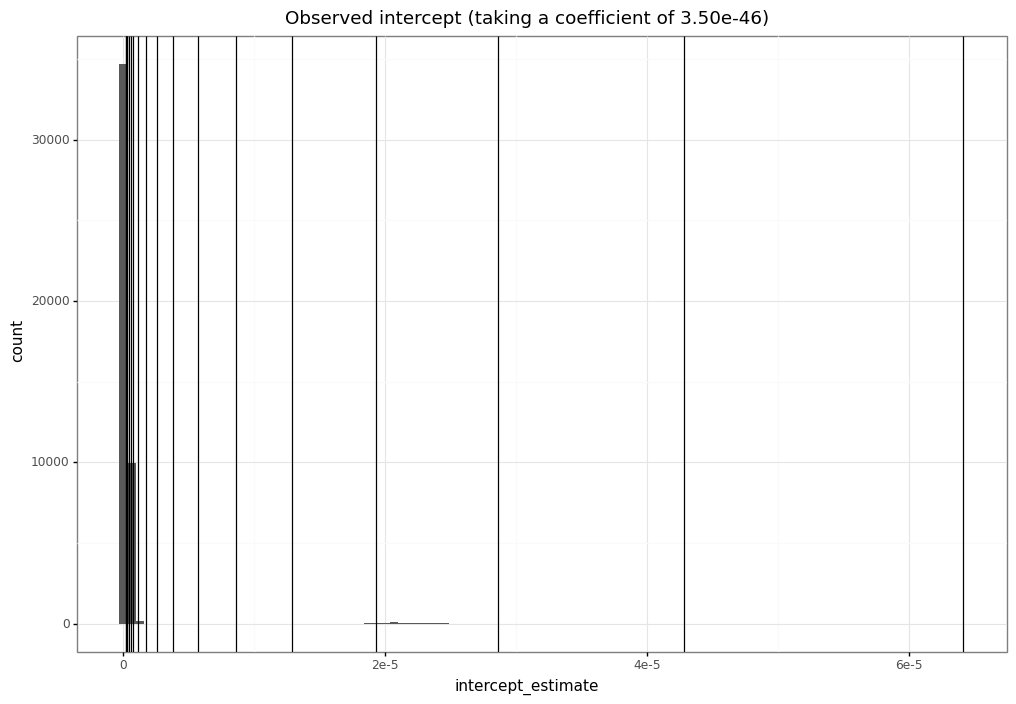

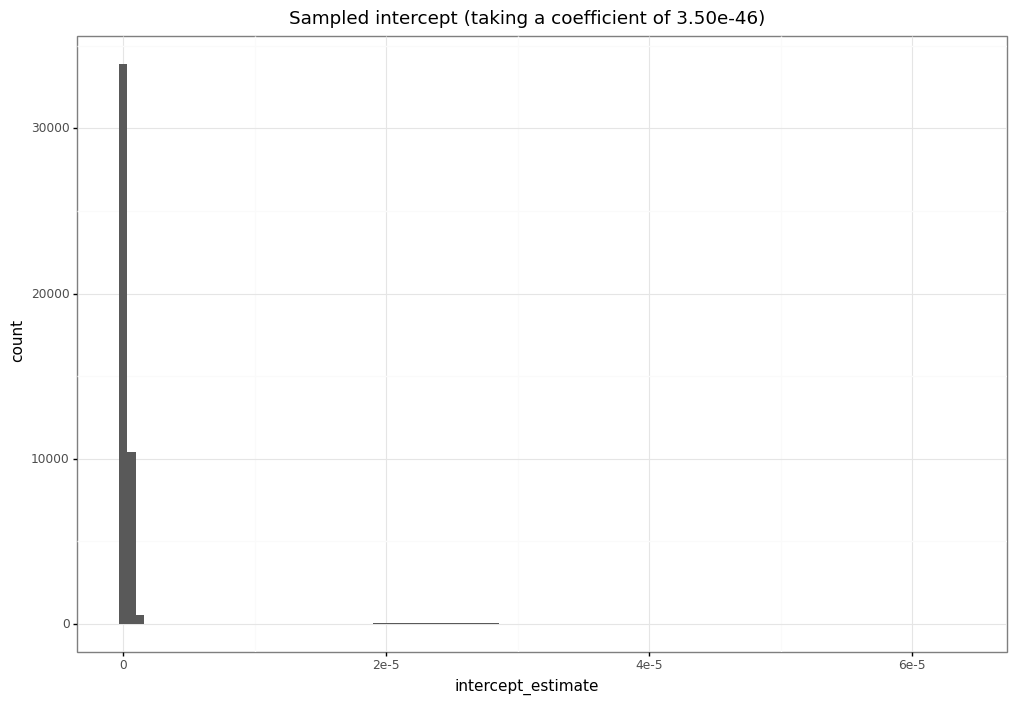


$heights

           1            2            3            4            5            6 
9.164613e+04 2.439058e+05 6.441590e+04 8.140506e+03 2.086730e+03 1.405177e+04 
           7            8            9           10           11           12 
5.995804e+02 0.000000e+00 0.000000e+00 5.235580e+00 0.000000e+00 2.617687e+00 
          13           14           15           16           17 
2.617687e+00 5.276954e+02 1.438912e+03 4.452888e+01 1.022436e+02 

$xbr
 [1] -15.320588 -15.160494 -15.079029 -14.885535 -14.545389 -14.175047
 [7] -13.859983 -13.481385 -13.099353 -12.717322 -12.335320 -11.953288
[13] -11.571272 -11.189255 -10.810248 -10.436355 -10.054580  -9.673138

$counts

         1          2          3          4          5          6          7 
14672.0000 19870.0000 12464.0334  2768.9666   772.8036  4427.1964   227.0000 
         8          9         10         11         12         13         14 
    0.0000     0.0000     2.0000     0.0000     1.0000     1.0000   200.0000 


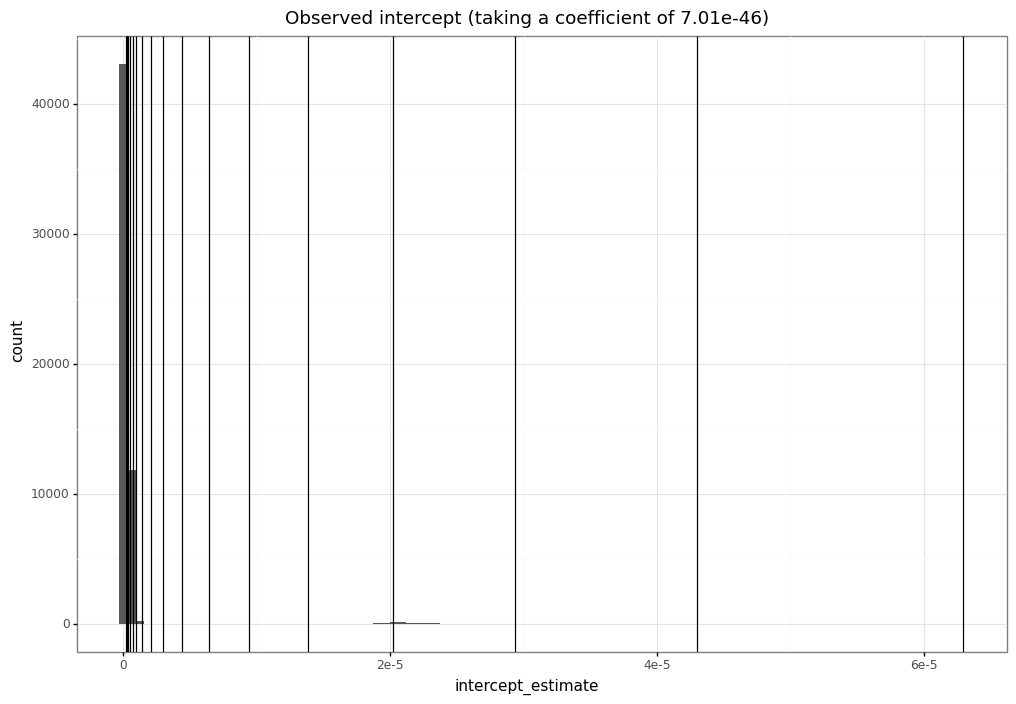

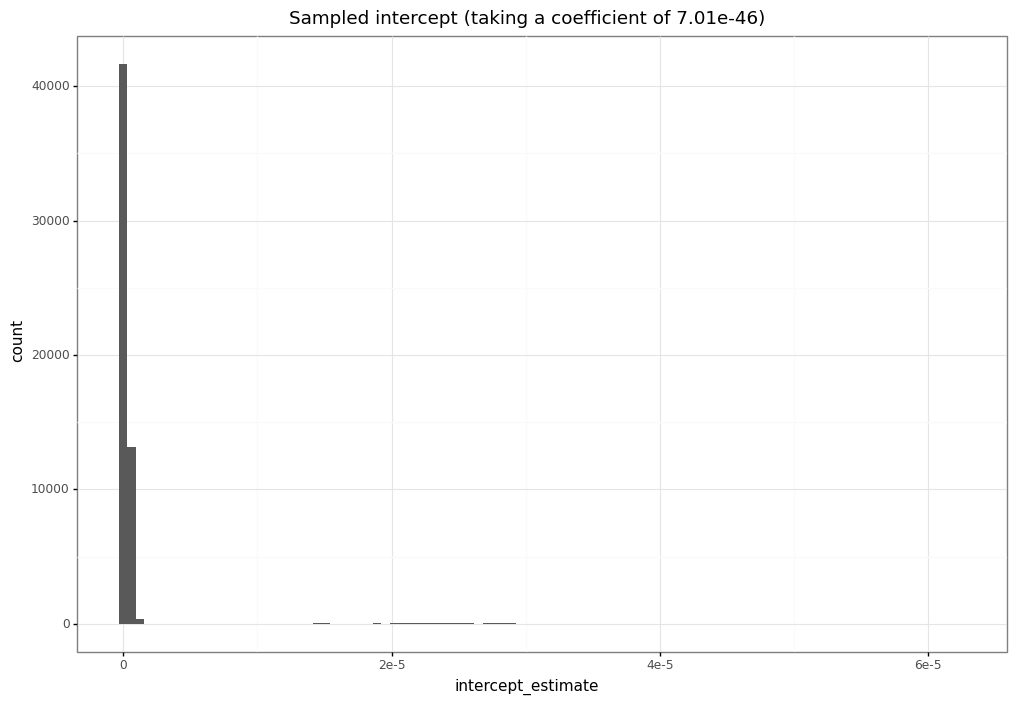

In [16]:
regressions_isend = SegmentedRegression()

for i, row in reg_isend.to_pandas().iterrows():
    regressions_isend.append(compute_mixture_regression(df_isend, row), row["min_x"], row["max_x"])


## Verification: generating the durations

In [17]:
isend_generated = pandas.DataFrame(dict(msg_size=df_isend.sample(n=100000).msg_size))
isend_generated['duration'] = isend_generated.apply(lambda row: regressions_isend.sample(row['msg_size']), axis=1)
isend_generated.head()

msg_size      duration
336962        87  6.611125e-07
51821     175986  2.681947e-07
177658    202171  3.058781e-07
67027      63305  3.790672e-06
36601     779429  3.160106e-07

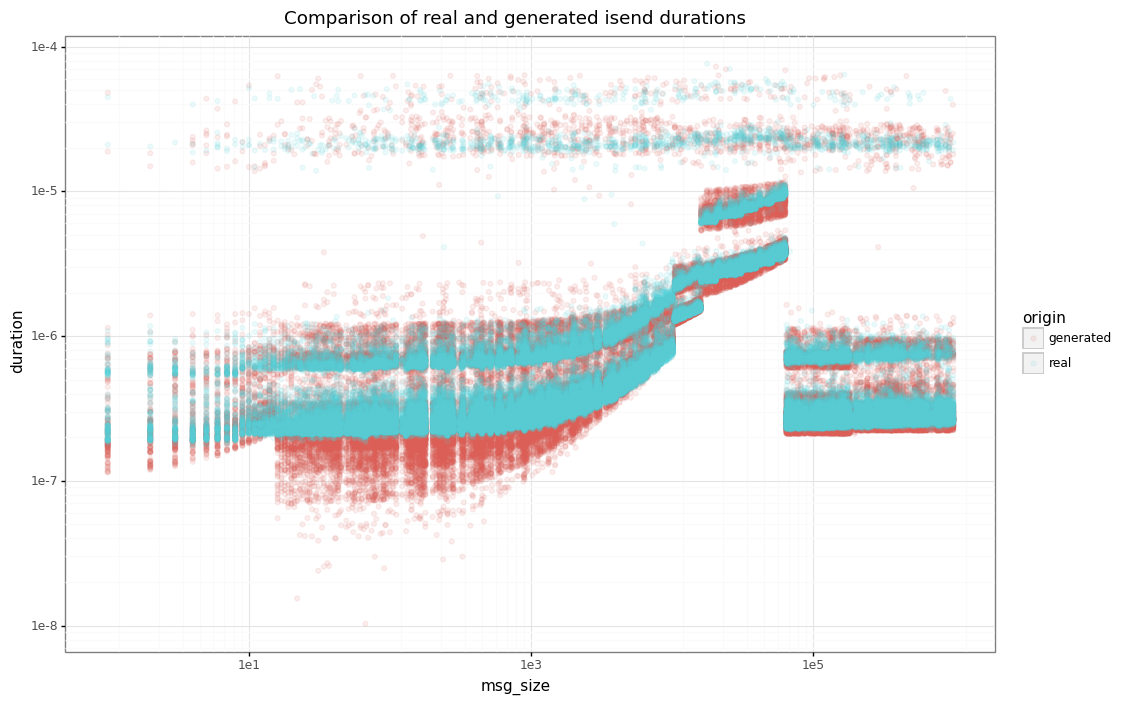

<ggplot: (8779366465744)>

In [18]:
df_isend['origin'] = 'real'
isend_generated['origin'] = 'generated'
tmp = pandas.concat([isend_generated, df_isend.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + ggtitle('Comparison of real and generated isend durations')
plot

## MPI_Recv

x ≤ 6.330e+04?
    └──x ≤ 8.319e+03?
    │    └──x ≤ 8.000e+00?
    │    │    └──y ~ 9.184e-41x + 1.169e-06
    │    │    └──y ~ 8.064e-11x + 1.385e-06
    │    └──y ~ 1.142e-10x + 9.005e-07
    └──y ~ 7.947e-11x + 1.102e-05


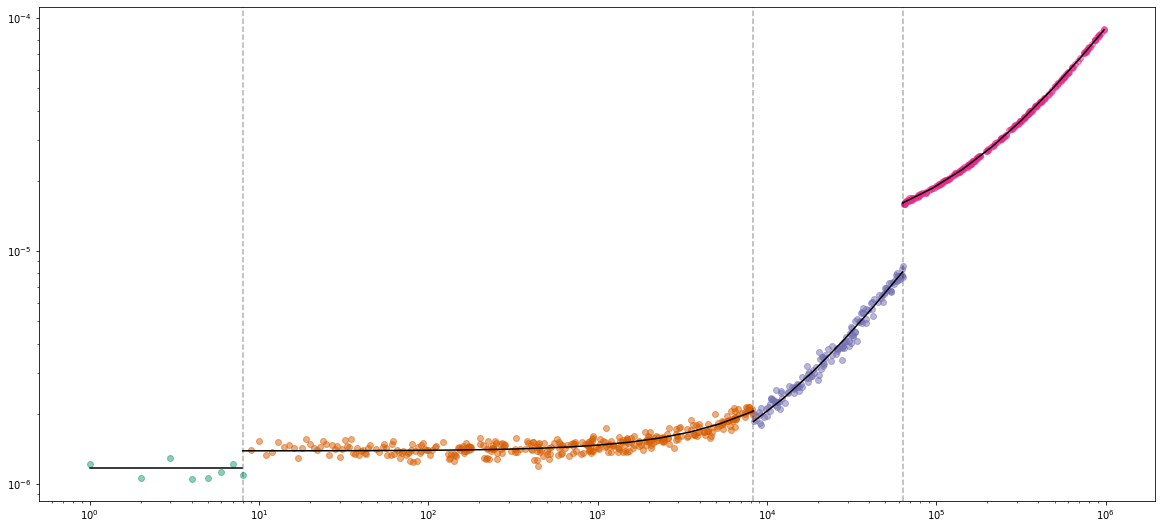

In [19]:
df_agg = aggregate_dataframe(df_recv)
reg_recv = compute_regression(df_agg['msg_size'], df_agg['duration'], mode='log')
print(reg_recv)
reg_recv.plot_dataset(log=True)

In [20]:
reg_recv.to_pandas()

min_x    max_x     intercept   coefficient           RSS           MSE  \
0     -inf      8.0  1.168595e-06  9.183550e-41  5.613748e-14  7.017185e-15   
1      8.0   8319.0  1.384813e-06  8.063524e-11  2.195685e-12  6.116114e-15   
2   8319.0  63305.0  9.005121e-07  1.141521e-10  7.967418e-12  5.207463e-14   
3  63305.0      inf  1.101944e-05  7.947166e-11  7.212706e-12  3.535640e-14   

     RSSlog  weighted_RSS  statsmodels_intercept  statsmodels_coefficient  
0  0.049335  7.798068e-15           1.169807e-06            -6.738429e-09  
1  0.952213  7.174899e-16           1.384719e-06             8.193791e-11  
2  0.466268  1.230864e-20           9.005121e-07             1.143139e-10  
3  0.007425  2.320690e-22           1.101944e-05             7.945817e-11

$heights

          1           2           5           6           7           8 
12805.56100 25919.79798 10367.82179  3621.83185   243.81370   655.46710 
          9          10          11          12          13 
12526.13661  6280.71153   550.38629    34.81460    35.32356 

$xbr
 [1] -14.11122 -14.08108 -14.03491 -13.99823 -13.90653 -13.53798 -13.26855
 [8] -13.23777 -13.18015 -12.89085 -12.43765 -11.98469

$counts

         1          2          5          6          7          8          9 
 386.00000 1196.73068  380.28059  332.13009   89.85864  176.60220  385.45000 
        10         11         12         13 
 361.94780  159.22172   15.77828   16.00000 




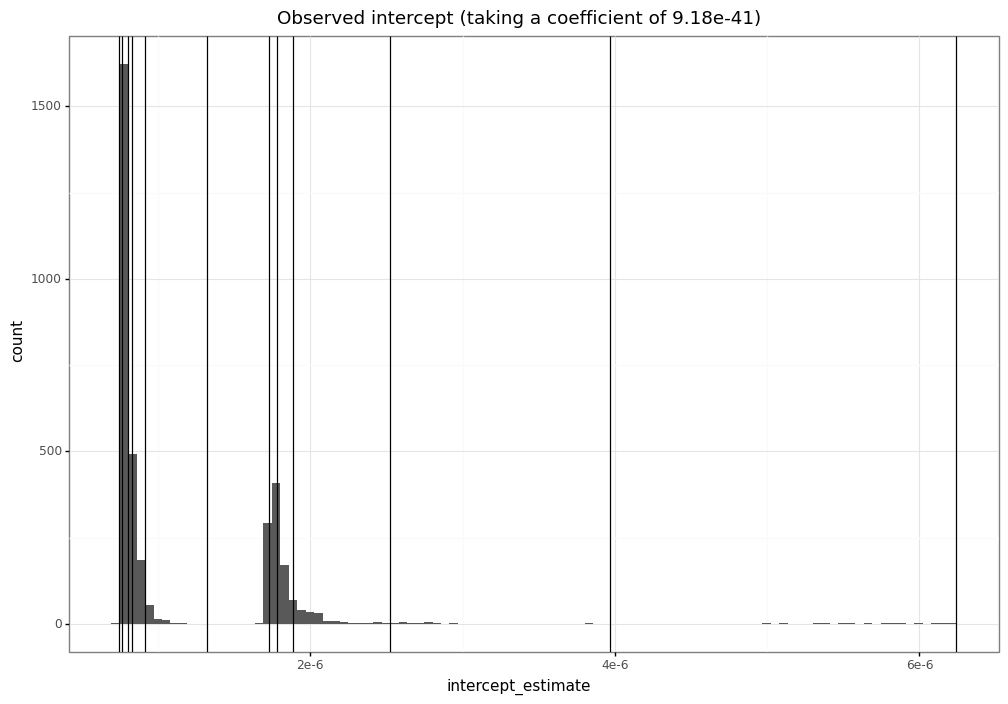

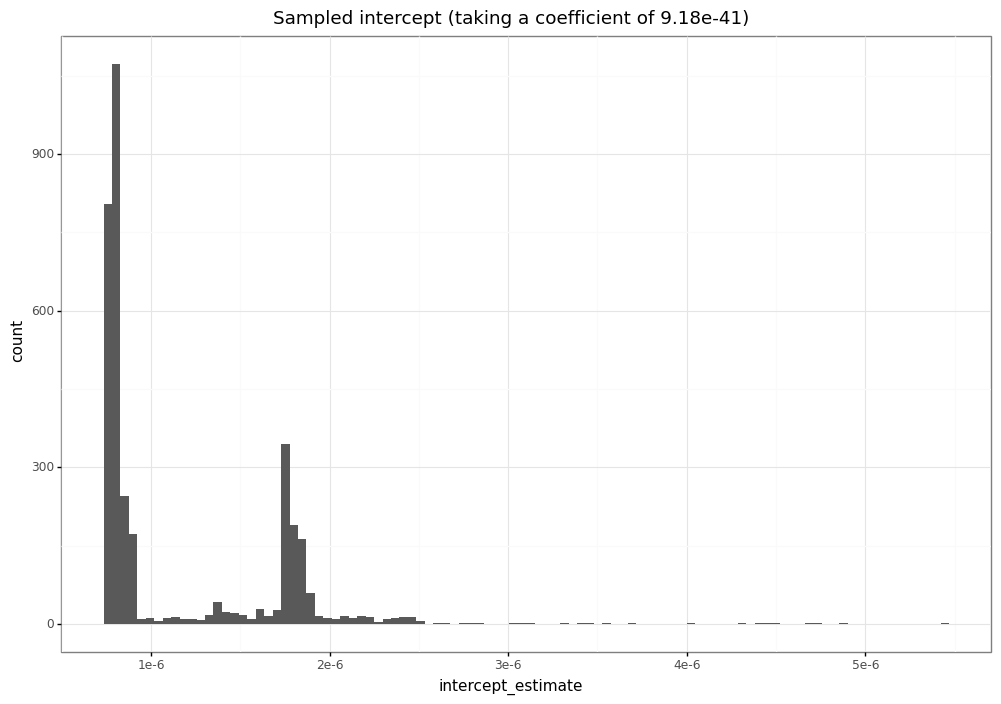


$heights

          1           2           3           4           8           9 
 13923.5643 154188.9223 349343.9867 816636.6385 329555.4348  51471.3264 
         10          11          12          13          14          15 
   287.6171 101039.6191 382982.9050 186487.1370  34554.8232    262.6745 
         16          17          18          19 
  1267.1391    205.4131    168.1484    170.6308 

$xbr
 [1] -14.31646 -14.00807 -13.91792 -13.87250 -13.78946 -13.74163 -13.55450
 [8] -13.15119 -13.02801 -12.98616 -12.90865 -12.68123 -12.27769 -11.88310
[15] -11.47904 -11.07464 -10.67025

$counts

        1         2         3         4         8         9        10        11 
 4293.926 13899.870 15868.416 67815.756 15762.511  9631.521   116.000 12446.013 
       12        13        14        15        16        17        18        19 
16025.921 14455.849  7858.217   106.000   500.000    83.000    68.000    69.000 




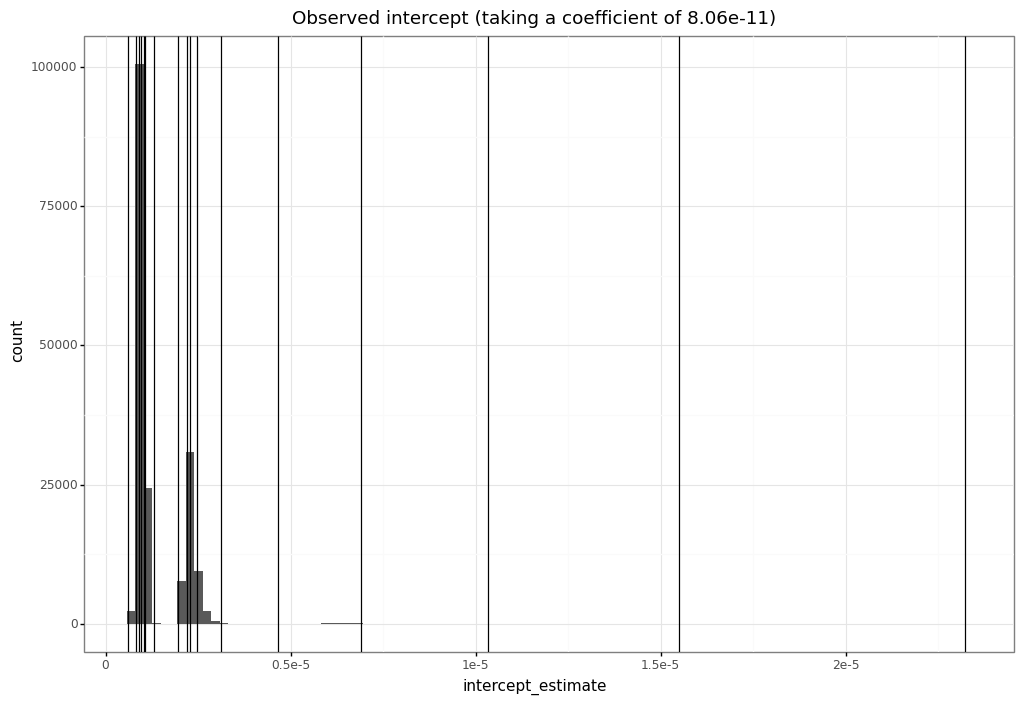

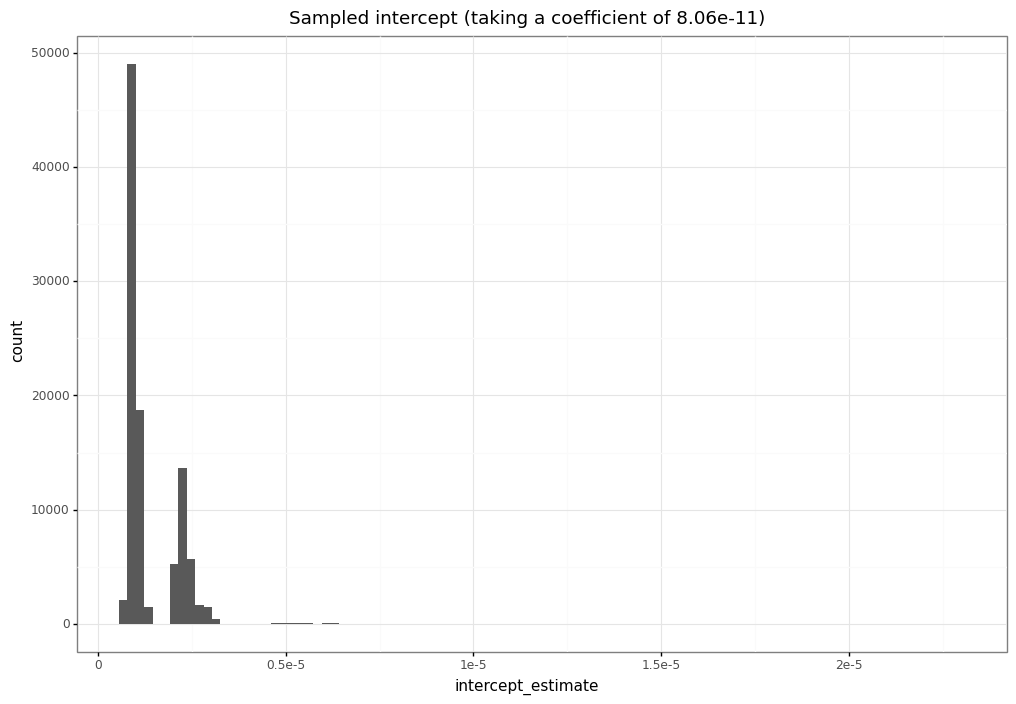


$heights

           1            2            3            4            5            6 
    5.246219    14.271024    47.704028   191.964577   627.383854  1637.637995 
           7            8            9           10           11           12 
 3609.850667  7674.033423 15096.514262 17610.787822  1467.314480  5333.021095 
          13           14           15           16           17           18 
48567.468959 34834.628490 34564.743564 24294.973274  6858.185028   450.211888 

$xbr
 [1] -23.60712 -22.27282 -20.94146 -19.62081 -18.34454 -17.18576 -16.23093
 [8] -15.52028 -15.05489 -14.76942 -14.51701 -13.53298 -12.95212 -12.84806
[15] -12.70731 -12.56557 -12.37257 -11.87254 -10.66866

$counts

       1        2        3        4        5        6        7        8 
   7.000   19.000   63.000  245.000  727.000 1563.662 2565.338 3571.439 
       9       10       11       12       13       14       15       16 
4309.541 4445.143 1443.878 3097.753 5053.728 4903.176 4899.146 4688.868 
  

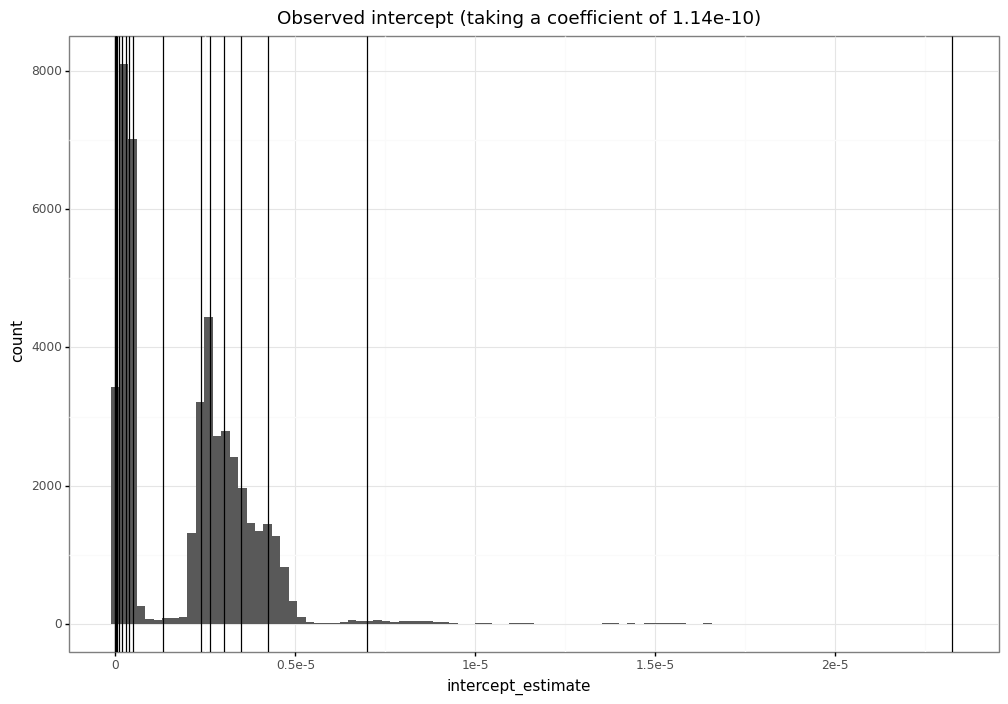

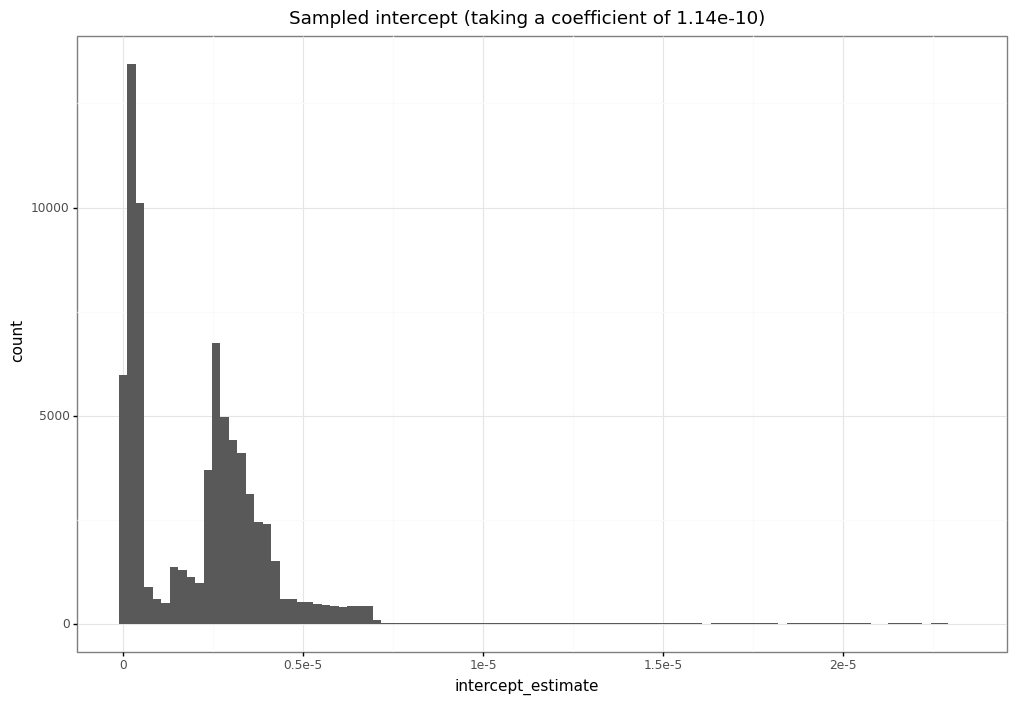


$heights

           1            2            3            4            5            6 
9.815768e+04 4.302166e+05 4.708475e+05 3.886927e+05 2.408280e+05 3.220171e+05 
           7            8            9           10           11           12 
3.476660e+05 7.983050e+04 3.951081e+03 5.936706e+03 2.078052e+03 1.420423e+03 
          13           14           15           16           17           18 
1.244728e+03 1.310296e+02 1.378049e+01 1.378049e+01 0.000000e+00 6.889888e+00 

$xbr
 [1] -11.627040 -11.543406 -11.509040 -11.476985 -11.439887 -11.388132
 [7] -11.345603 -11.305341 -11.214520 -11.073546 -10.934580 -10.791658
[13] -10.648039 -10.504232 -10.359227 -10.214094 -10.068961  -9.923814
[19]  -9.778673

$counts

        1         2         3         4         5         6         7         8 
 8209.365 14784.635 15093.000 14419.909 12463.952 13695.139 13997.719  7250.281 
        9        10        11        12        13        14        15        16 
  557.000   825.000   297.0

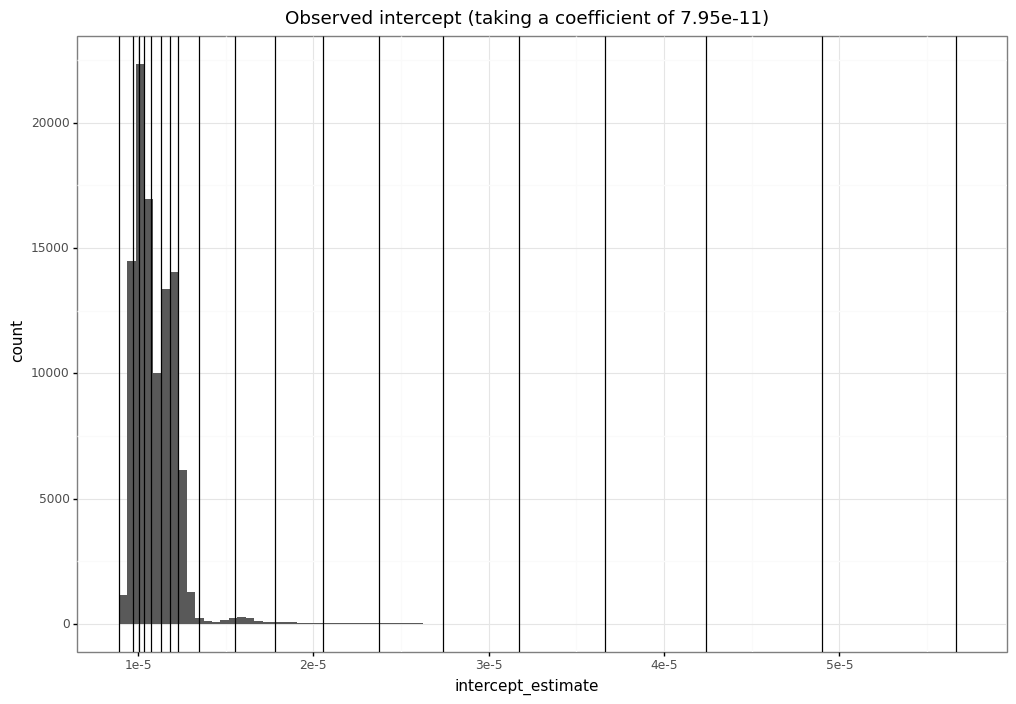

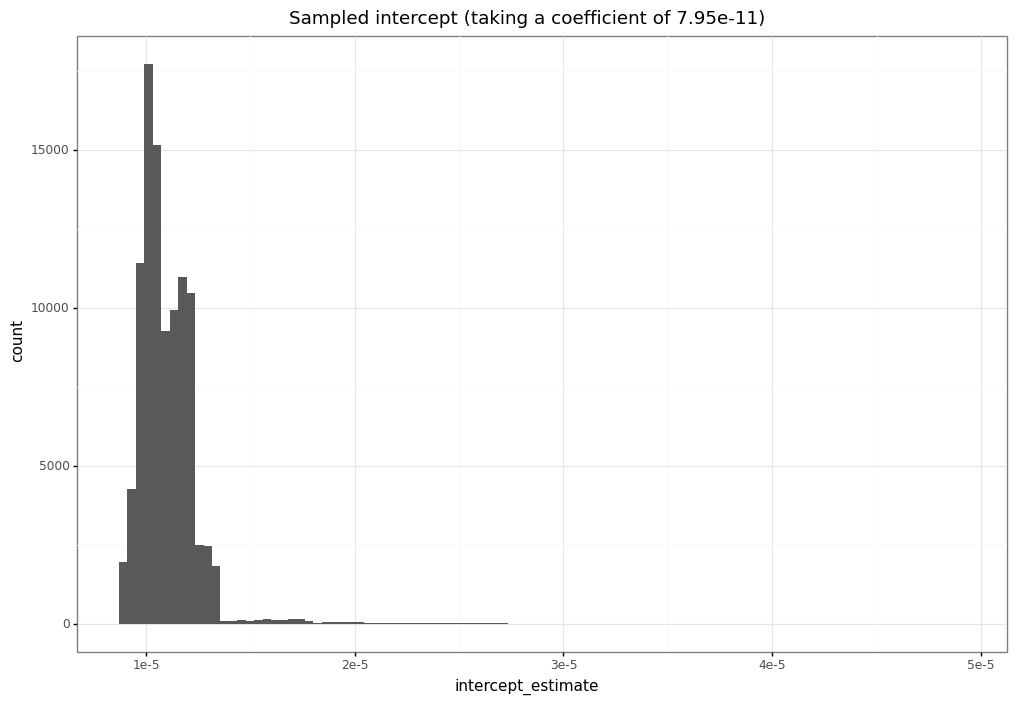

In [21]:
regressions_recv = SegmentedRegression()

for i, row in reg_recv.to_pandas().iterrows():
    regressions_recv.append(compute_mixture_regression(df_recv, row), row["min_x"], row["max_x"])


## Verification: generating the durations

In [22]:
recv_generated = pandas.DataFrame(dict(msg_size=df_recv.sample(n=100000).msg_size))
recv_generated['duration'] = recv_generated.apply(lambda row: regressions_recv.sample(row['msg_size']), axis=1)
recv_generated.head()

msg_size  duration
176732     21354  0.000005
29916         30  0.000003
223247        44  0.000002
232172       323  0.000001
327939    165312  0.000024

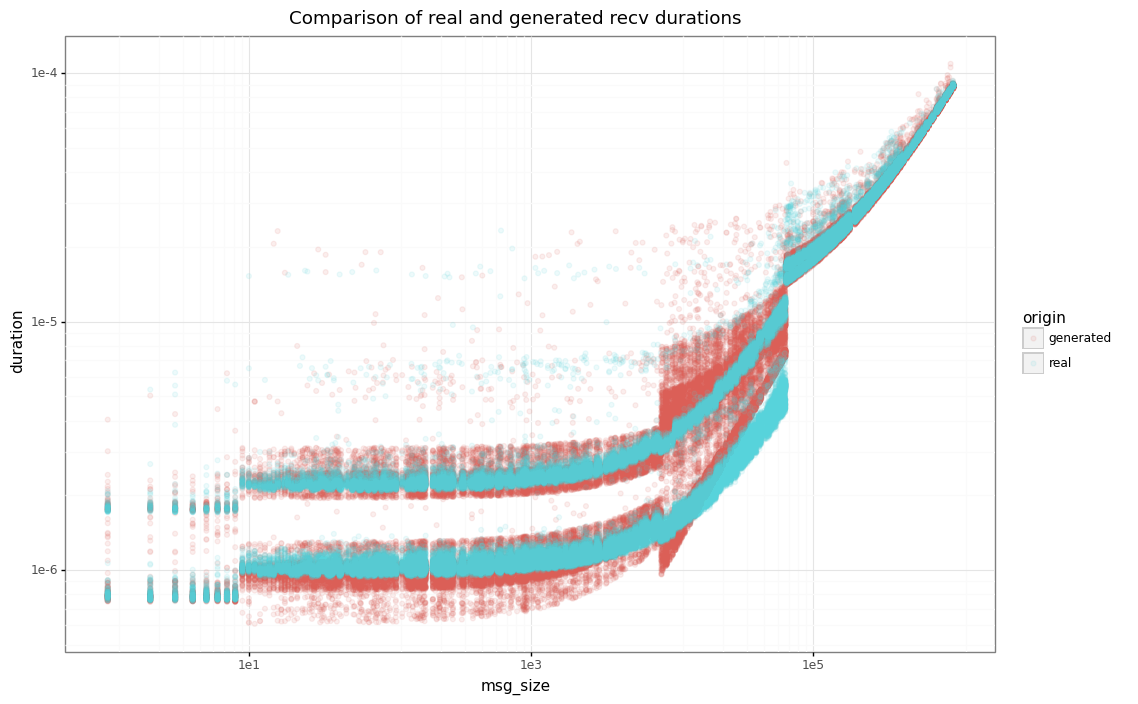

<ggplot: (8779366215921)>

In [23]:
df_recv['origin'] = 'real'
recv_generated['origin'] = 'generated'
tmp = pandas.concat([recv_generated, df_recv.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + ggtitle('Comparison of real and generated recv durations')
plot

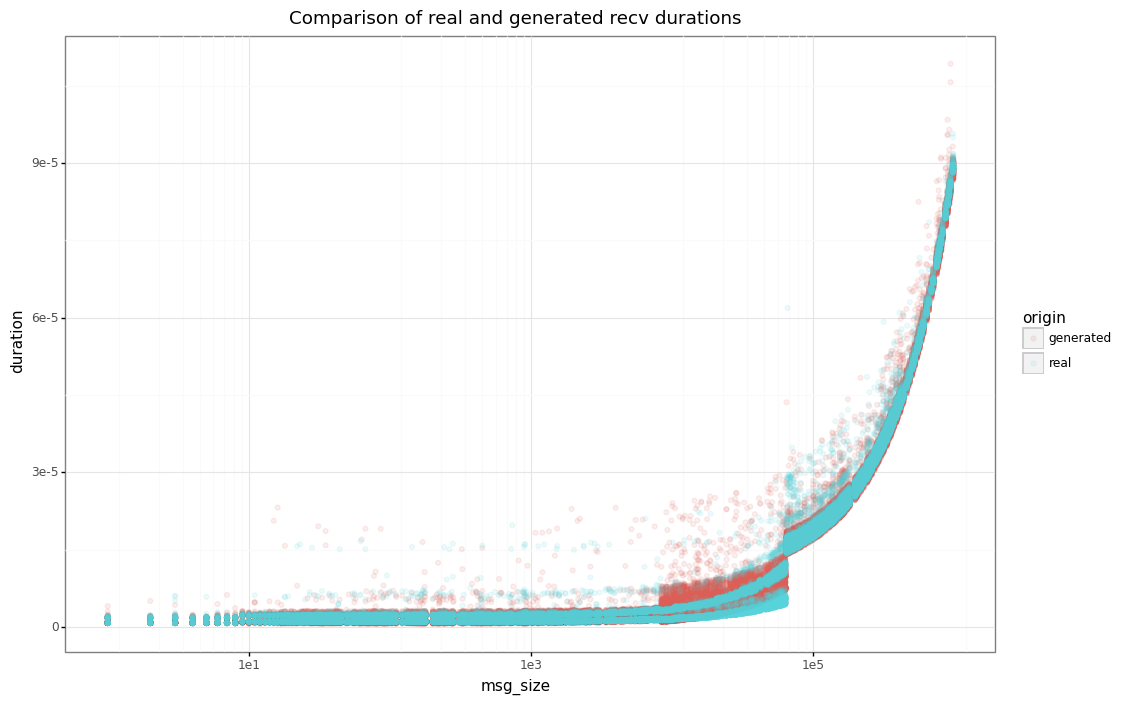

<ggplot: (8779366185213)>

In [24]:
df_recv['origin'] = 'real'
recv_generated['origin'] = 'generated'
tmp = pandas.concat([recv_generated, df_recv.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + ggtitle('Comparison of real and generated recv durations')
plot

### Code extraction

In [25]:
regressions_recv

AttributeError: 'numpy.float64' object has no attribute 'to_tex'

In [26]:
regressions_recv.pretty_c()

```c
double smpi_stochastic_intercept=-1, smpi_stochastic_coefficient=-1;
if(smpi_stochastic_size < 8) {
    FIXME
}
if(8 <= smpi_stochastic_size && smpi_stochastic_size < 8319) {
    FIXME
}
if(8319 <= smpi_stochastic_size && smpi_stochastic_size < 63305) {
    FIXME
}
if(63305 <= smpi_stochastic_size) {
    FIXME
}

```

## One analysis TEMP

In [27]:
reg = None
for _, row in reg_send.to_pandas().iterrows():
    reg = row
    break

# df_send
df = df_send.copy()
df = df[df.msg_size > reg["min_x"]]
df = df[df.msg_size < reg["max_x"]]
reg_coeff = max(0, reg["coefficient"])  # a negative coefficient does not make any sense (may happen with MPI_Irecv)
df['intercept_estimate'] = df['duration'] - df['msg_size'] * reg_coeff
%Rpush df

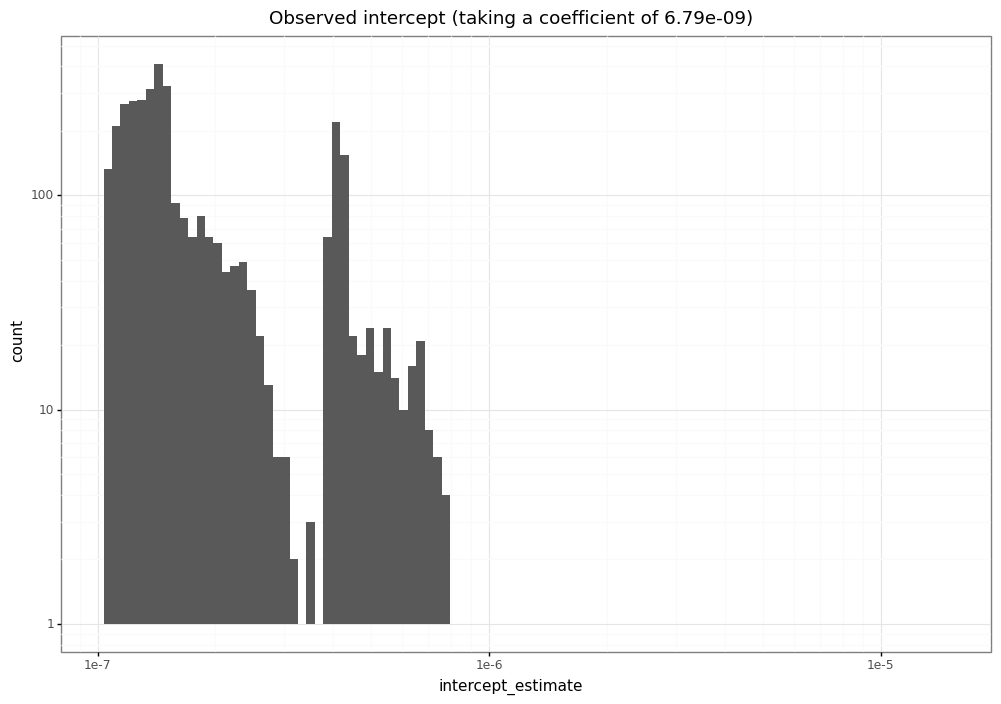

In [28]:
plot = ggplot(df[df.intercept_estimate > 0], aes(x='intercept_estimate')) + geom_histogram(bins=100) + theme_bw()
plot = plot + scale_x_log10() + scale_y_log10() + ggtitle('Observed intercept (taking a coefficient of %.2e)' % reg_coeff)
print(plot)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




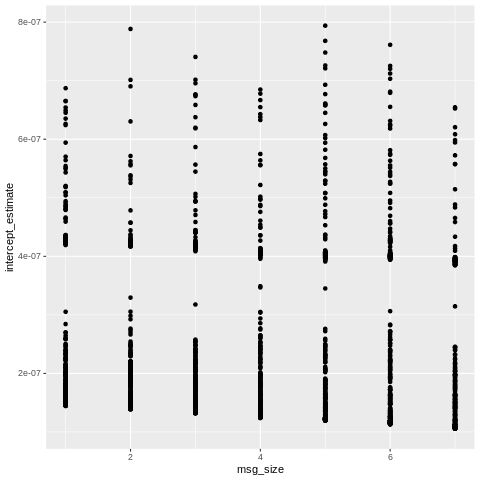

In [29]:
%%R

library(dplyr)
library(ggplot2)
summary(df)
df = df %>% filter(intercept_estimate < 5e-6)
df %>%
ggplot(aes(x=msg_size, y=intercept_estimate)) + geom_point()

In [30]:
%%R
dh = dhist(df$intercept_estimate, plot=FALSE)
dh

$heights

          1           2           3           4           5           6 
40777799709 43793461288 55531252952 20109645363  6540901896  2473177905 
          7           8           9          10          11          12 
  184866523  5533755574  3055681820   787903661   523911024   456784359 
         13 
  122408212 

$xbr
 [1] 1.054988e-07 1.204988e-07 1.346424e-07 1.462141e-07 1.718565e-07
 [6] 2.198565e-07 2.848429e-07 3.659826e-07 4.173039e-07 4.791559e-07
[11] 5.553074e-07 6.335649e-07 7.123767e-07 7.940706e-07

$counts

       1        2        3        4        5        6        7        8 
611.6670 619.3936 642.5943 515.6588 313.9633 160.7230  15.0000 284.0000 
       9       10       11       12       13 
189.0000  60.0000  41.0000  36.0000  10.0000 



$heights

       1        2        3        4        5 
9.557306 6.572260 3.545079 9.000541 9.557306 

$xbr
[1] -16.06457 -15.75067 -15.33029 -14.68945 -14.35999 -14.04609

$counts

       1        2        3        4        5 
3.000000 2.762840 2.271828 2.965332 3.000000 




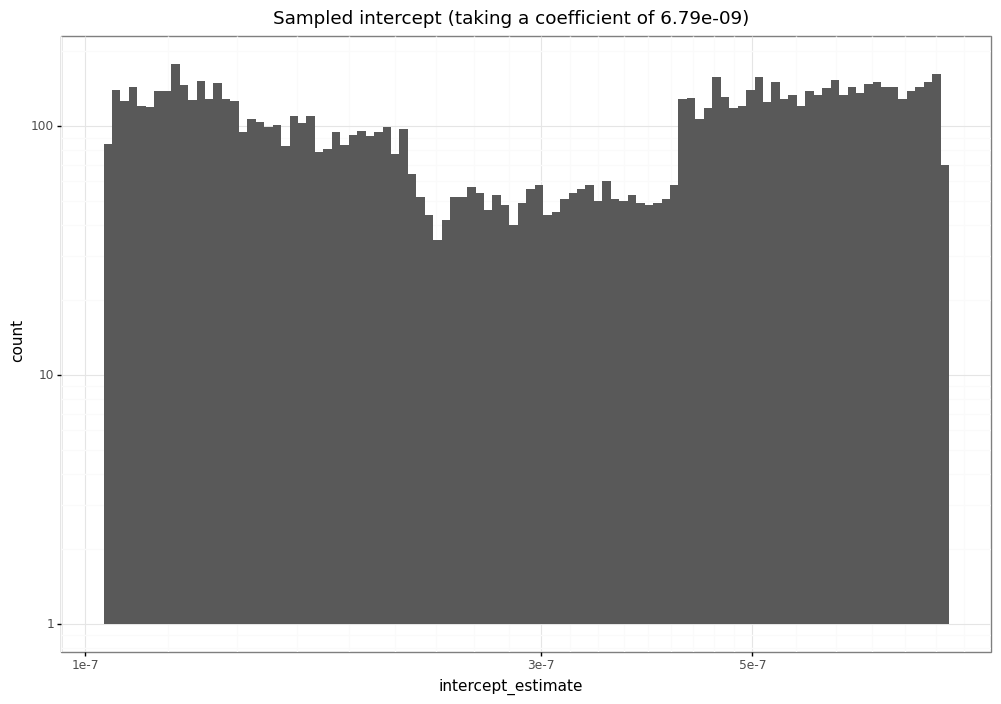

In [31]:
%Rpull dh

xbr = dh[1]
height= dh[0]
pdh = Dhist(xbr, height)

plot = ggplot(pandas.DataFrame({'intercept_estimate': [pdh.sample() for _ in range(10000)]}), aes(x='intercept_estimate')) + geom_histogram(bins=100) + theme_bw()
plot = plot + scale_x_log10() + scale_y_log10() + ggtitle('Sampled intercept (taking a coefficient of %.2e)' % reg_coeff)
print(plot)

### ahist/ckmeans

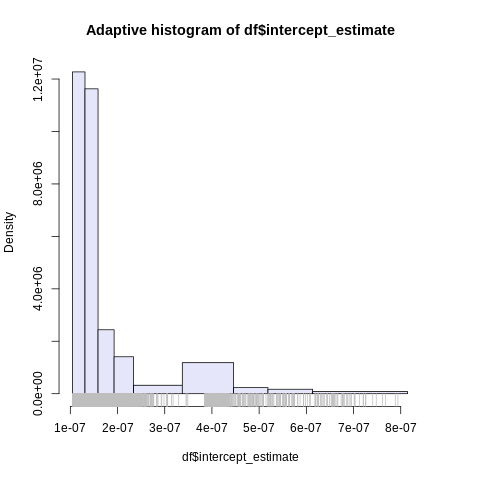

In [32]:
%%R
ahist(df$intercept_estimate)

In [33]:
%%R
res <- Ckmeans.1d.dp(df$intercept_estimate)
print(summary(df))
print(summary(res))
print(res$centers)
print(res$size)
print(res$withinss)

      op               msg_size         start            duration        
 Length:3499        Min.   :1.000   Min.   : 0.2003   Min.   :1.510e-07  
 Class :character   1st Qu.:2.000   1st Qu.:14.3932   1st Qu.:1.560e-07  
 Mode  :character   Median :4.000   Median :30.8475   Median :1.580e-07  
                    Mean   :3.999   Mean   :30.3963   Mean   :2.282e-07  
                    3rd Qu.:6.000   3rd Qu.:45.7296   3rd Qu.:2.270e-07  
                    Max.   :7.000   Max.   :63.0828   Max.   :8.280e-07  
  experiment            type            deployment            index       
 Length:3499        Length:3499        Length:3499        Min.   :  2260  
 Class :character   Class :character   Class :character   1st Qu.:165129  
 Mode  :character   Mode  :character   Mode  :character   Median :357878  
                                                          Mean   :348434  
                                                          3rd Qu.:524189  
                                

In [34]:
%%R

res = Cksegs.1d.dp(df$intercept_estimate)
summary(res)

             Length Class  Mode     
cluster      3499   -none- numeric  
centers         7   -none- numeric  
withinss        7   -none- numeric  
size            7   -none- numeric  
totss           1   -none- numeric  
tot.withinss    1   -none- numeric  
betweenss       1   -none- numeric  
BIC             9   -none- numeric  
xname           1   -none- character
yname           1   -none- character


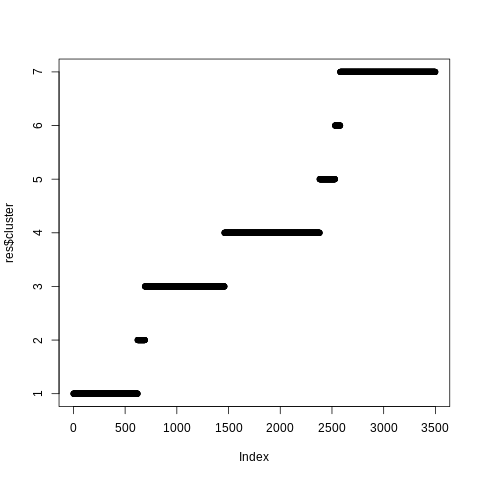

In [35]:
%%R

plot(res$cluster)

### quantile regression

In [36]:
import statsmodels.formula.api as smf

mod = smf.quantreg('duration ~ msg_size', df)
res = mod.fit(q=.05)
print(res.summary())
print(res.params.Intercept)

                         QuantReg Regression Results                          
Dep. Variable:               duration   Pseudo R-squared:               -1.706
Model:                       QuantReg   Bandwidth:                   1.479e-08
Method:                 Least Squares   Sparsity:                    1.049e-07
Date:                Thu, 21 Oct 2021   No. Observations:                 3500
Time:                        13:07:48   Df Residuals:                     3498
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.667e-07   2.94e-09     56.623      0.000    1.61e-07    1.72e-07
msg_size    6.811e-10    6.6e-10      1.032      0.302   -6.13e-10    1.98e-09
1.6666435046919737e-07


In [37]:
ols = smf.ols(data=df, formula='duration ~ msg_size').fit()
print(ols.summary())
print(ols.params)

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.040
Date:                Thu, 21 Oct 2021   Prob (F-statistic):             0.0445
Time:                        13:07:48   Log-Likelihood:                 47933.
No. Observations:                3500   AIC:                        -9.586e+04
Df Residuals:                    3498   BIC:                        -9.585e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.137e-07   1.03e-08     20.712      0.0

In [53]:
%%R -i df
library(quantreg)
qtr = rq(formula='duration ~ msg_size', data=df, tau=0.05)
qtr

Call:
rq(formula = "duration ~ msg_size", tau = 0.05, data = df)

Coefficients:
 (Intercept)     msg_size 
1.526667e-07 3.333333e-10 

Degrees of freedom: 3500 total; 3498 residual


In [52]:
%Rpull qtr
qtr[0][1]

3.3333333333333746e-10